# Setting up

## load modules

In [1]:
%%capture
%load_ext autoreload
%autoreload 2
import sys
import os
import gc
import psutil
import numpy as np
import xarray as xr
import holoviews as hv
import matplotlib.pyplot as plt
import bokeh.plotting as bpl
import dask.array as da
import pandas as pd
import dask
import datashader as ds
import itertools as itt
import papermill as pm
import ast
import functools as fct
import panel as pn
from holoviews.operation.datashader import datashade, regrid, dynspread
from datashader.colors import Sets1to3
from dask.diagnostics import ProgressBar
from IPython.core.display import display, HTML
from dask.distributed import Client, progress, LocalCluster, fire_and_forget

## set path and parameters

In [2]:
#Set up Initial Basic Parameters#
minian_path = "./minian_snapshot"
dpath = "./data/pfd2/ts45-4/s10/"
subset = None
subset_mc = None
interactive = True
output_size = 100
param_save_minian = {
    'dpath': dpath,
    'fname': 'minian',
    'backend': 'zarr',
    'meta_dict': {'session': -1, 'animal': -2},
    'overwrite': True}

#Pre-processing Parameters#
param_load_videos = {
    'pattern': 'msCam[0-9]+\.avi$',
    'dtype': np.uint8,
    'downsample': {'frame': 2},
    'downsample_strategy': 'subset'}
param_denoise = {
    'method': 'median',
    'ksize': 9}
param_background_removal = {
    'method': 'tophat',
    'wnd': 15}

#Motion Correction Parameters#
subset_mc = None
param_estimate_shift = {
    'dim': 'frame',
    'on': 'max'}

#Initialization Parameters#
param_seeds_init = {
    'wnd_size': 10000,
    'method': 'rolling',
    'stp_size': 10000,
    'nchunk': 100,
    'max_wnd': 5}
param_gmm_refine = {
    'q': (0.1, 99.9),
    'n_components': 2,
    'valid_components': 1,
    'mean_mask': True}
param_pnr_refine = {
    'noise_freq': 0.06,
    'thres': 1,
    'med_wnd': None}
param_ks_refine = {
    'sig': 0.05}
param_seeds_merge = {
    'thres_dist': 5,
    'thres_corr': 0.7,
    'noise_freq': .06}
param_initialize = {
    'thres_corr': 0.5,
    'wnd': 10}

#CNMF Parameters#
param_get_noise = {
    'noise_range': (0.06, 0.5),
    'noise_method': 'logmexp'}
param_first_spatial = {
    'dl_wnd': 10,
    'sparse_penal': 0.05,
    'update_background': False,
    'post_scal': True,
    'zero_thres': 'eps'}
param_first_temporal = {
    'noise_freq': 0.06,
    'sparse_penal': 1,
    'p': 1,
    'add_lag': 20,
    'use_spatial': False,
    'jac_thres': 0.2,
    'zero_thres': 1e-8,
    'max_iters': 200,
    'use_smooth': True,
    'scs_fallback': False,
    'post_scal': True}
param_first_merge = {
    'thres_corr': 0.8}
param_second_spatial = {
    'dl_wnd': 5,
    'sparse_penal': 0.01,
    'update_background': True,
    'post_scal': True,
    'zero_thres': 'eps'}
param_second_temporal = {
    'noise_freq': 0.06,
    'sparse_penal': 0.1,
    'p': 1,
    'add_lag': 20,
    'use_spatial': False,
    'jac_thres': 0.2,
    'zero_thres': 1e-8,
    'max_iters': 500,
    'use_smooth': True,
    'scs_fallback': False,
    'post_scal': True}
param_second_merge = {
    'thres_corr': 0.7}

In [3]:
%%capture
sys.path.append(minian_path)
from minian.utilities import load_params, load_videos, scale_varr, scale_varr_da, save_variable, open_minian, save_minian, handle_crash, get_optimal_chk, rechunk_like
from minian.preprocessing import remove_brightspot, gradient_norm, denoise, remove_background, stripe_correction
from minian.motion_correction import estimate_shift_fft, apply_shifts, interpolate_frame, mask_shifts
from minian.initialization import seeds_init, gmm_refine, pnr_refine, intensity_refine, ks_refine, seeds_merge, initialize
from minian.cnmf import get_noise_fft, update_spatial, compute_trace, update_temporal, unit_merge, smooth_sig
from minian.visualization import VArrayViewer, CNMFViewer, generate_videos, visualize_preprocess, visualize_seeds, visualize_gmm_fit, visualize_spatial_update, visualize_temporal_update, roi_draw

## visualization imports

In [4]:
import functools as fct
import itertools as itt
import numpy as np
import holoviews as hv
import xarray as xr
import ipywidgets as iwgt
import pandas as pd
import colorsys
import param
import dask.array as da
import panel as pn
import os
import dask
import ffmpeg
import seaborn as sns
import matplotlib.pyplot as plt
from uuid import uuid4
from collections import OrderedDict
from holoviews.streams import Stream, Pipe, RangeXY, DoubleTap, Tap, Selection1D, BoxEdit
from holoviews.operation import contours, threshold
from holoviews.operation.datashader import datashade, regrid, dynspread
from holoviews.util import Dynamic
from datashader.colors import Sets1to3
from datashader import count_cat
from datashader import mean as dsmean
from datashader import count as dscount
from IPython.core.display import display, clear_output
from bokeh.io import push_notebook, show
from bokeh.layouts import layout
from bokeh.plotting import figure
from bokeh.models import Slider, Range1d, LinearAxis
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler
from bokeh.palettes import Category10_10, Viridis256
from matplotlib.colors import rgb_to_hsv
from scipy.ndimage.measurements import center_of_mass
from IPython.core.debugger import set_trace
from dask.diagnostics import ProgressBar
from skvideo.io import FFmpegWriter, vwrite
from scipy import linalg
from bokeh import models
from bokeh.io import export_svgs
from panel.interact import interact as pninteract
from panel.layout import Row, Column
from panel import widgets as pnwgt
from scipy.spatial import cKDTree

## module initialization

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>div.prompt { width:0.1px !important; min-width:0.1px !important; display:none !important }</style>"))
display(HTML("<style>div.output_subarea { max-width:100% !important;}</style>"))

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
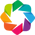

In [6]:
dpath = os.path.abspath(dpath)
pbar = ProgressBar(minimum=2)
pbar.register()
hv.notebook_extension('bokeh', width=100)

SMALL_SIZE = 8
MEDIUM_SIZE = 11
BIG_SIZE = 11
sns.set(rc={
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': MEDIUM_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': MEDIUM_SIZE, # size of faceting titles
    'xtick.labelsize': SMALL_SIZE,
    'ytick.labelsize': SMALL_SIZE,
    'legend.fontsize': MEDIUM_SIZE,
    'figure.titlesize': BIG_SIZE,
    'legend.edgecolor': 'gray',
    'axes.linewidth': 0.4,
    'axes.facecolor': 'white',
    'xtick.major.size': 2,
    'xtick.major.width': 0.4,
    'xtick.minor.visible': True,
    'xtick.minor.size': 1,
    'xtick.minor.width': 0.4,
    'ytick.major.size': 2,
    'ytick.major.width': 0.4,
    'ytick.minor.visible': True,
    'ytick.minor.size': 1,
    'ytick.minor.width': 0.4,
})
sns.set_style('ticks')

## capturing guideline

elife requires a minimum figure size of 10cm/3.94in, and 20cm/7.87in for full page figure, with "legible" font size

Conforming to the guideline, we assume a 10pt font size and 7.87in width by default unless otherwise required.

plugging in the common assumptions that:
1. default display dpi is 96 px/in
1. 1 pt is defined as 1/72 in
1. bokeh's default fontsize is 10pt

we have:
1. the unitless ratio between 1 unit of figure width and 1 unit of font size is: `r = 7.87in / (10pt * 1/72in/pt)`
1. the maxmum width of the snapshot in pixels is hence `max_width = 10pt * 1/72in/pt * 96px/in * r`

Hence, all snapshots are captured with chrome developer tools with a width of 756 pixels.
`output_size` parameters are adjusted accordingly so that everything fits nicely.
Finally a DPR of 5 is chosen to achieve a final dpi of `756 / 7.87 * 5 = 480`.

In [ ]:
r = 7.87 / (10 / 72)
max_width = 10 / 72 * 96 * r
print(max_width)

# Pre-processing

## loading videos and visualization

In [7]:
%%time
varr = load_videos(dpath, **param_load_videos)
chk = get_optimal_chk(varr.astype(float), [('frame',), ('height', 'width')])

loading 27 videos in folder /media/share/hdda/phild/minian_paper_data/data/pfd2/ts45-4/s10
CPU times: user 4.86 s, sys: 156 ms, total: 5.01 s
Wall time: 7.4 s


## monkey-patch vaviewer

In [8]:
class VArrayViewer():
    def __init__(self, varr, framerate=30, rerange=None, summary=['mean'],
                 meta_dims=None, datashading=True, layout=False, cols=1):
        if isinstance(varr, list):
            for iv, v in enumerate(varr):
                varr[iv] = v.assign_coords(data_var=v.name)
            self.ds = xr.concat(varr, dim='data_var')
            meta_dims=['data_var']
        elif isinstance(varr, xr.DataArray):
            self.ds = varr.to_dataset()
        elif isinstance(varr, xr.Dataset):
            self.ds = varr
        else:
            raise NotImplementedError(
                "video array of type {} not supported".format(type(varr)))
        try:
            self.meta_dicts = OrderedDict(
                [(d, list(self.ds.coords[d].values)) for d in meta_dims])
            self.cur_metas = OrderedDict(
                [(d, v[0]) for d, v in self.meta_dicts.items()])
        except TypeError:
            self.meta_dicts = dict()
            self.cur_metas = dict()
        self._datashade = datashading
        self._layout = layout
        self.framerate = framerate
        self._f = self.ds.coords['frame'].values
        self._h = self.ds.sizes['height']
        self._w = self.ds.sizes['width']
        self.mask = dict()
        self.rerange = rerange
        CStream = Stream.define(
            'CStream',
            f=param.Integer(default=int(self._f.min()), bounds=(self._f.min(), self._f.max())))
        self.strm_f = CStream()
        self.str_box = BoxEdit()
        self.widgets = self._widgets()
        if type(summary) is list:
            summ_all = {
                'Mean': self.ds.mean(['height', 'width']),
                'Max': self.ds.max(['height', 'width']),
                'Min': self.ds.min(['height', 'width']),
                'Diff': self.ds.diff('frame').mean(['height', 'width'])
            }
            try:
                summ = {k: summ_all[k] for k in summary}
            except KeyError:
                print("{} Not understood for specifying summary".format(summary))
            if summ:
                print("computing summary")
                sum_list = []
                for k, v in summ.items():
                    sum_list.append(v.compute().assign_coords(sum_var=k))
                summary = xr.concat(sum_list, dim='sum_var')
        self.summary = summary
        if layout:
            self.ds_sub = self.ds
            self.sum_sub = self.summary
        else:
            self.ds_sub = self.ds.sel(**self.cur_metas)
            try:
                self.sum_sub = self.summary.sel(**self.cur_metas)
            except AttributeError:
                self.sum_sub = self.summary
        self.pnplot = pn.panel(self.get_hvobj(cols))

    def get_hvobj(self, cols=1):
        def get_im_ovly(meta, title=None):
            def img(f, ds):
                return (hv.Image(
                    ds.sel(frame=f).compute(), kdims=['width', 'height'])
                    .opts(xlabel='Width (px)', ylabel='Height (px)'))
            try:
                curds = (self.ds_sub.sel(**meta)
                         .rename("_".join(meta.values())))
            except ValueError:
                curds = self.ds_sub
            fim = fct.partial(img, ds=curds)
            im = (regrid(hv.DynamicMap(fim, streams=[self.strm_f]))
                  .opts(frame_width=500, aspect=self._w/self._h, cmap='Viridis'))
            if title:
                im = im.opts(title=title)
            if self.rerange:
                im = im.redim.range(**{vname: self.rerange})
            self.xyrange = RangeXY(source=im).rename(x_range='w', y_range='h')
            if not self._layout:
                hv_box = hv.Polygons([]).opts(
                    style={'fill_alpha': 0.3, 'line_color': 'white'})
                self.str_box = BoxEdit(source=hv_box)
                im_ovly = im * hv_box
            else:
                im_ovly = im
            def hist(f, w, h, ds):
                if w and h:
                    cur_im = (hv.Image(
                        ds.sel(frame=f).compute(), kdims=['width', 'height'])
                              .select(height=h, width=w))
                else:
                    cur_im = hv.Image(
                        ds.sel(frame=f).compute(), kdims=['width', 'height'])
                return (hv.operation.histogram(cur_im, num_bins=50)
                        .opts(xlabel='Fluorescence (A.U.)', ylabel='Frequency'))
            fhist = fct.partial(hist, ds=curds)
            his = (hv.DynamicMap(fhist, streams=[self.strm_f, self.xyrange])
                   .opts(frame_height=int(500*self._h/self._w), width=150, cmap='Viridis'))
            im_ovly = (im_ovly << his).map(lambda p: p.opts(style=dict(cmap='Viridis')))
            return im_ovly
        if self._layout and self.meta_dicts:
            im_dict = OrderedDict()
            for meta in itt.product(*list(self.meta_dicts.values())):
                mdict = {k: v for k, v in zip(list(self.meta_dicts.keys()), meta)}
                
                im_dict[meta] = get_im_ovly(mdict, title=meta[0])
            # ims = hv.NdLayout(im_dict, kdims=list(self.meta_dicts.keys()))
            ims = hv.Layout(list(im_dict.values())).cols(4)
        else:
            ims = get_im_ovly(self.cur_metas)
        if self.summary is not None:
            hvsum = (hv.Dataset(self.sum_sub)
                     .to(hv.Curve, kdims=['frame']).opts(xlabel='Frame', ylabel='Fluorescence (A.U.)')
                     .overlay('sum_var'))
            if self._datashade:
                hvsum = datashade_ndcurve(hvsum, kdim='sum_var')
            try:
                hvsum = hvsum.layout(list(self.meta_dicts.keys()))
            except:
                pass
            vl = (hv.DynamicMap(lambda f: hv.VLine(f), streams=[self.strm_f])
                  .opts(style=dict(color='red')))
            summ = ((hvsum * vl).map(
                lambda p: p.opts(frame_width=500, aspect=3),
                [hv.RGB, hv.Curve]))
        else:
            summ = hv.Div('')
        hvobj = (ims + summ).cols(cols)
        return hvobj

    def show(self):
        return pn.layout.Column(self.widgets, self.pnplot)

    def _widgets(self):
        w_play = pnwgt.Player(
            length=len(self._f), interval=10,
            value=0, width=650, height=90)
        def play(f):
            if not f.old == f.new:
                self.strm_f.event(f=int(self._f[f.new]))
        w_play.param.watch(play, 'value')
        w_box = pnwgt.Button(
            name='Update Mask',
            button_type='primary',
            width=100,
            height=30)
        w_box.param.watch(self._update_box, 'clicks')
        if not self._layout:
            wgt_meta = {d: pnwgt.Select(
                name=d, options=v, height=45, width=120)
                        for d, v in self.meta_dicts.items()}
            def make_update_func(meta_name):
                def _update(x):
                    self.cur_metas[meta_name] = x.new
                    self._update_subs()
                return _update
            for d, wgt in wgt_meta.items():
                cur_update = make_update_func(d)
                wgt.param.watch(cur_update, 'value')
            wgts = pn.layout.WidgetBox(
                w_box, w_play, *list(wgt_meta.values()))
        else:
            wgts = pn.layout.WidgetBox(
                w_box, w_play)
        return wgts

    def _update_subs(self):
        self.ds_sub = self.ds.sel(**self.cur_metas)
        if self.sum_sub is not None:
            self.sum_sub = self.summary.sel(**self.cur_metas)
        self.pnplot.objects[0].object = self.get_hvobj()

    def _update_box(self, click):
        box = self.str_box.data
        self.mask.update({
            tuple(self.cur_metas.values()): {
                'height': slice(box['y0'][0], box['y1'][0]),
                'width': slice(box['x0'][0], box['x1'][0])}})

## capture vaviewer

In [ ]:
vaviewer = VArrayViewer(varr, framerate=5, summary=['Min', 'Mean', 'Max'], datashading=False)

In [ ]:
hv.output(size=output_size)
display(vaviewer.show())

## subset part of video

In [9]:
varr_ref = varr.sel(subset)

## glow removal and visualization

In [10]:
varr_min = varr_ref.min('frame').compute()
varr_ref = varr_ref - varr_min

[########################################] | 100% Completed |  1min 10.9s


## capture glow removal

In [ ]:
hv.output(size=80)
if interactive:
    vaviewer = VArrayViewer(
        [varr.rename('Original'), varr_ref.rename('Vignetting Correction')],
        framerate=5,
        summary=None,
        layout=True,
        cols=2)
    display(vaviewer.show())

## monkey patch visualization function

In [ ]:
def visualize_preprocess(fm, fn=None, include_org=True, **kwargs):
    fh, fw = fm.sizes['height'], fm.sizes['width']
    asp = fw / fh
    opts_im = {
        'plot': {'frame_width': 500, 'aspect': asp,
                 'title': 'Image {label} {group} {dimensions}',
                 'xlabel': 'Width (px)', 'ylabel': 'Height (px)',
                },
        'style': {'cmap': 'viridis'}}
    opts_cnt = {
        'plot': {'frame_width': 500, 'aspect': asp,
                 'title': 'Contours {label} {group} {dimensions}',
                 'xlabel': 'Width (px)', 'ylabel': 'Height (px)'
                },
        'style': {'cmap': 'viridis'}}
    def _vis(f):
        im = (hv.Image(f, kdims=['width', 'height'])
                  .opts(**opts_im))
        cnt = (hv.operation.contours(im)
                   .opts(**opts_cnt))
        return im, cnt
    if fn is not None:
        pkey = kwargs.keys()
        pval = kwargs.values()
        im_dict = dict()
        cnt_dict = dict()
        for params in itt.product(*pval):
            fm_res = fn(fm, **dict(zip(pkey, params)))
            cur_im, cur_cnt = _vis(fm_res)
            cur_im = cur_im.relabel('After')
            cur_cnt = cur_cnt.relabel('After')
            p_str = tuple([str(p) if not isinstance(p, (int, float)) else p for p in params])
            im_dict[p_str] = cur_im
            cnt_dict[p_str] = cur_cnt
        hv_im = (regrid(hv.HoloMap(im_dict, kdims=list(pkey)), precompute=True)
                 .opts(**opts_im))
        hv_cnt = (datashade(
            hv.HoloMap(cnt_dict, kdims=list(pkey)), precompute=True, cmap=Viridis256)
                  .opts(**opts_cnt))
        if include_org:
            im, cnt = _vis(fm)
            im = regrid(im, precompute=True).relabel('Before').opts(**opts_im)
            cnt = (datashade(cnt, precompute=True, cmap=Viridis256)
                   .relabel('Before').opts(**opts_cnt))
            return (im + cnt + hv_im + hv_cnt).cols(2)
        else:
            return (hv_im + hv_cnt).cols(2)
    else:
        im, cnt = _vis(fm)
        im = im.relabel('Before')
        cnt = cnt.relabel('Before')
        return im + cnt

## capture parameter explore of denoise

In [ ]:
hv.output(size=80)
if interactive:
    display(visualize_preprocess(varr_ref.isel(frame=0), denoise, method=['median'], ksize=[5, 7, 9]))

## denoise params

In [11]:
de_data = dict()
for ksize in [3, 11, 21]:
    cur_re = denoise(varr_ref.isel(frame=0), method='median', ksize=ksize).transpose('height', 'width').values
    de_data[ksize] = cur_re
de_pd = pd.Series(de_data, name='data').reset_index().rename({'index': "Window Size"}, axis='columns')
de_pd2 = de_pd.copy()
de_pd['type'] = 'Image'
de_pd2['type'] = 'Contours'
de_pd = pd.concat([de_pd, de_pd2])

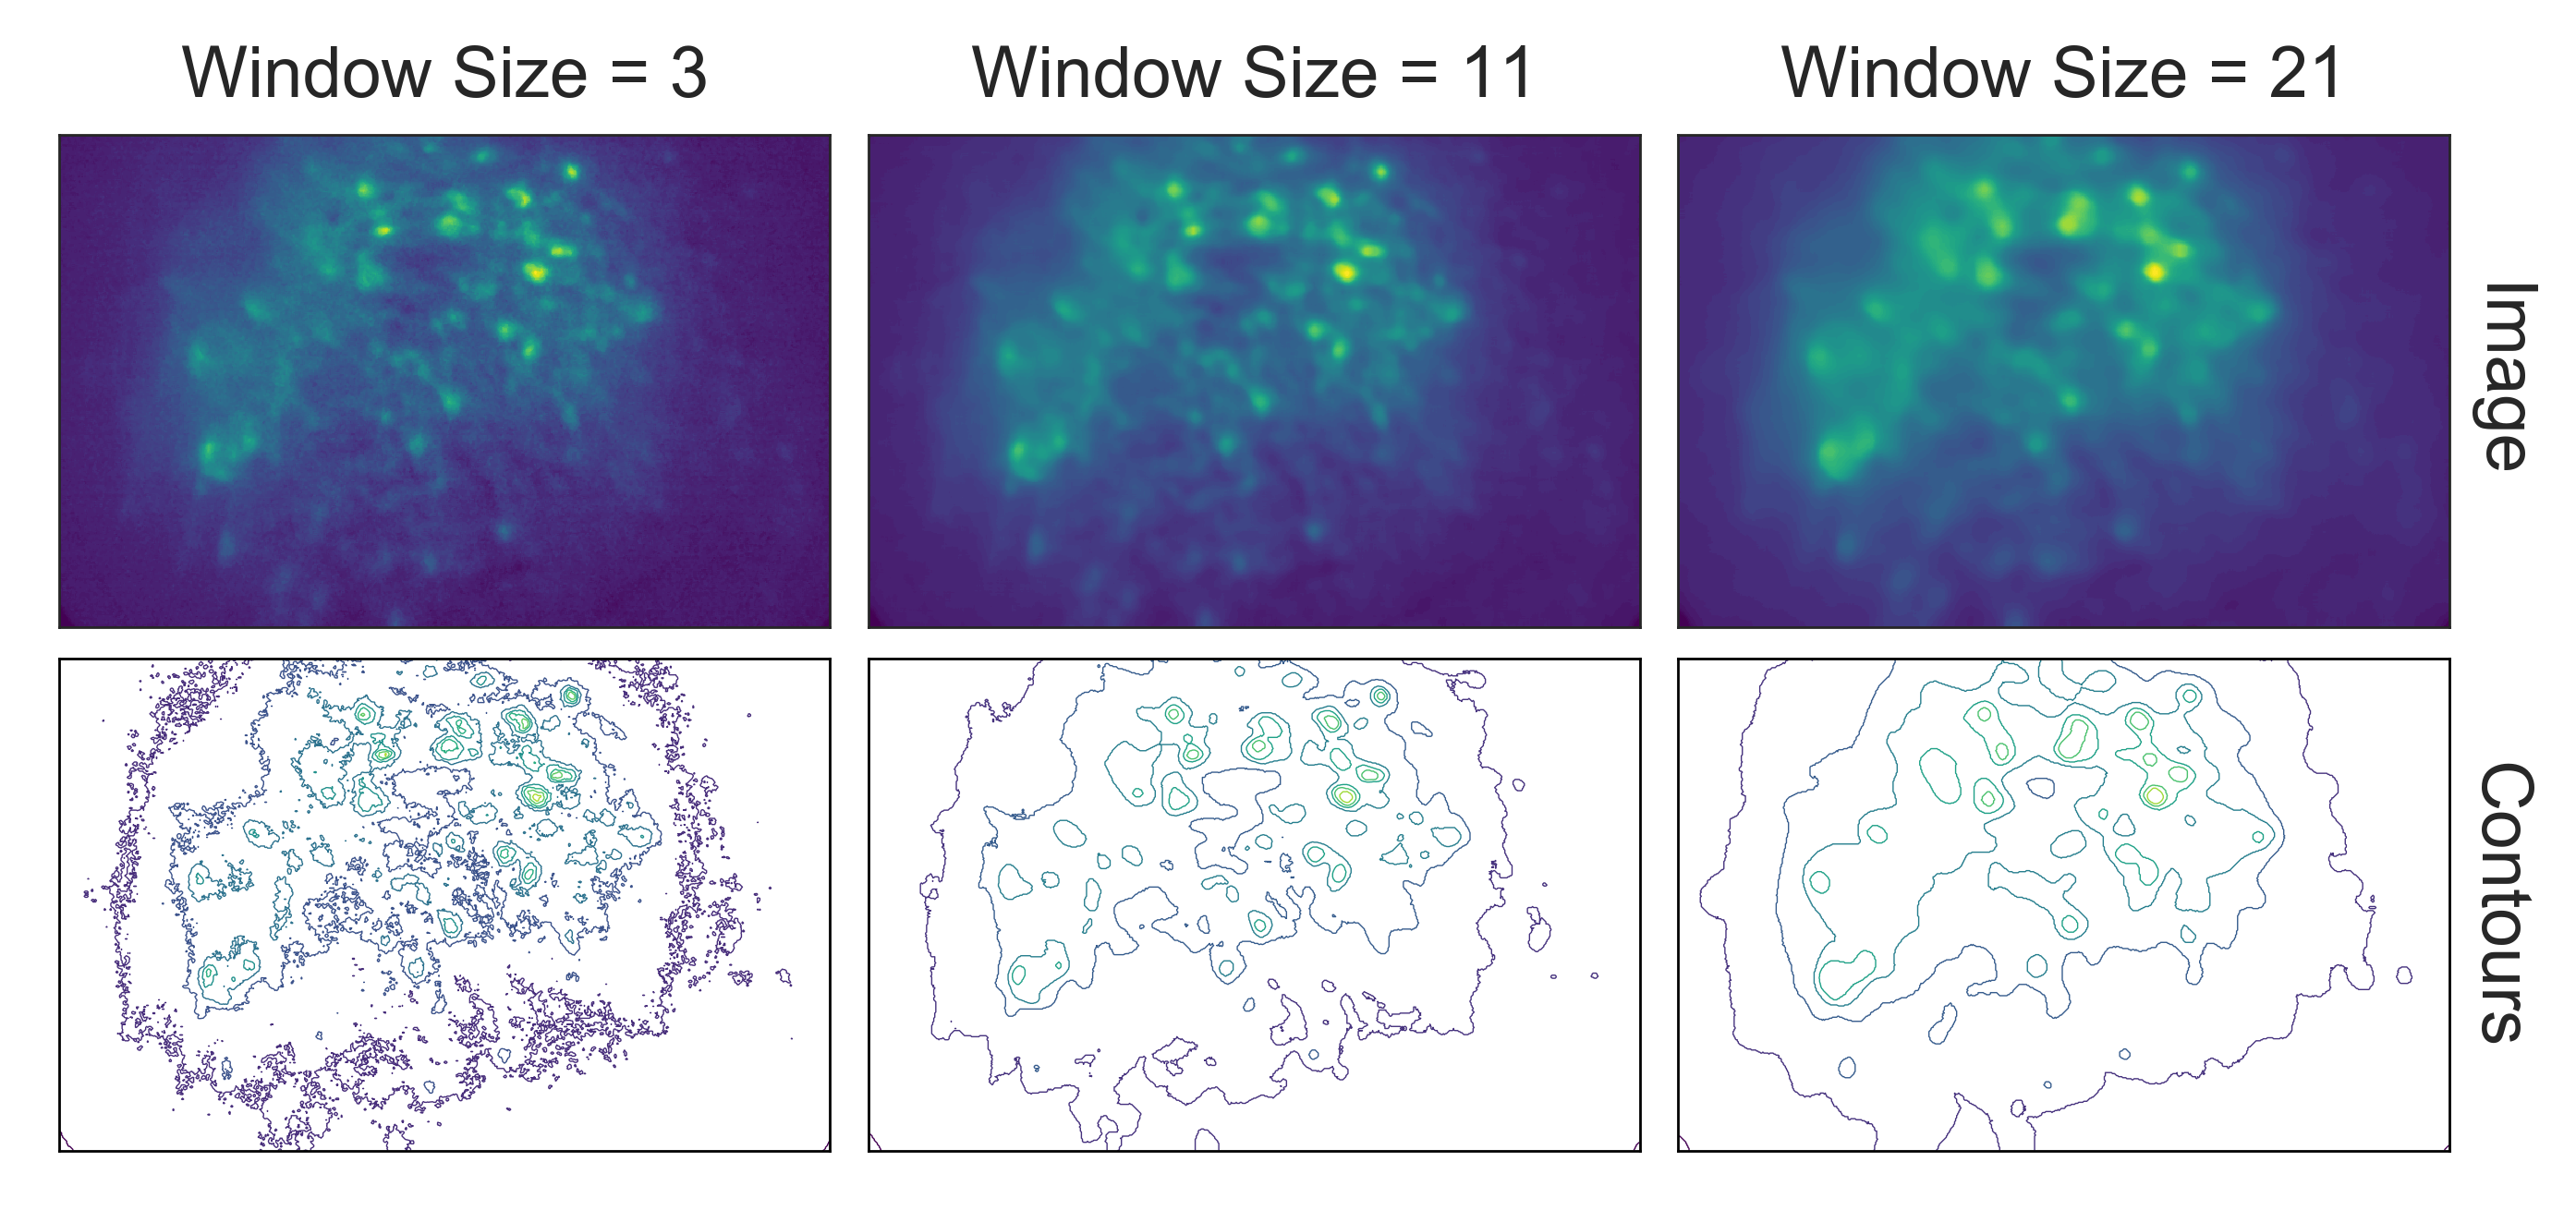

In [12]:
def plt_im(x, plt_type, color, **kwargs):
    plt_type = plt_type.values[0]
    x = x.values[0]
    if plt_type == 'Image':
        im = plt.imshow(x, cmap='viridis', **kwargs)
        ax = im.axes
        ax.invert_yaxis()
    elif plt_type == 'Contours':
        im = plt.contour(x, cmap='viridis', linewidths=0.2, **kwargs)
        ax = im.ax
        ax.set_aspect('equal')
        for sp in ['top', 'bottom', 'left', 'right']:
            ax.spines[sp].set_visible(True)
            ax.spines[sp].set_color('black')
            ax.spines[sp].set_linewidth(0.4)
    ax.margins(0)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return im

grid = sns.FacetGrid(
    de_pd, row='type', col='Window Size',
    margin_titles=True,
    despine=False,
)
aspect = 752*3/480/2
grid.map(plt_im, 'data', 'type')
for ax in grid.axes.flat:
    plt.setp(ax.texts, text="")
grid.set_titles(row_template="{row_name}")
for ax in grid.axes.flat:
    plt.setp(ax.texts, bbox={'alpha': 0})
grid.fig.set_dpi(500)
grid.fig.set_size_inches((5.51, 5.51/aspect))
grid.fig.subplots_adjust(hspace=0.05, wspace=0.05)
grid.savefig("./figs/denoise_params.svg")
grid.savefig("./figs/denoise_params.png")
grid.savefig("./figs/denoise_params.tiff")

## denoise

In [13]:
varr_ref = denoise(varr_ref, **param_denoise)

## capture parameter explore of background removal

In [ ]:
hv.output(size=80)
if interactive:
    display(visualize_preprocess(varr_ref.isel(frame=0), remove_background, method=['tophat'], wnd=[5, 10, 15]))

## background removal params

In [14]:
de_data = dict()
for wnd in [5, 20, 35]:
    cur_re = remove_background(varr_ref.isel(frame=0), method='tophat', wnd=wnd).transpose('height', 'width').values
    de_data[wnd] = cur_re
de_pd = pd.Series(de_data, name='data').reset_index().rename({'index': "Window Size"}, axis='columns')
de_pd2 = de_pd.copy()
de_pd['type'] = 'Image'
de_pd2['type'] = 'Contours'
de_pd = pd.concat([de_pd, de_pd2])

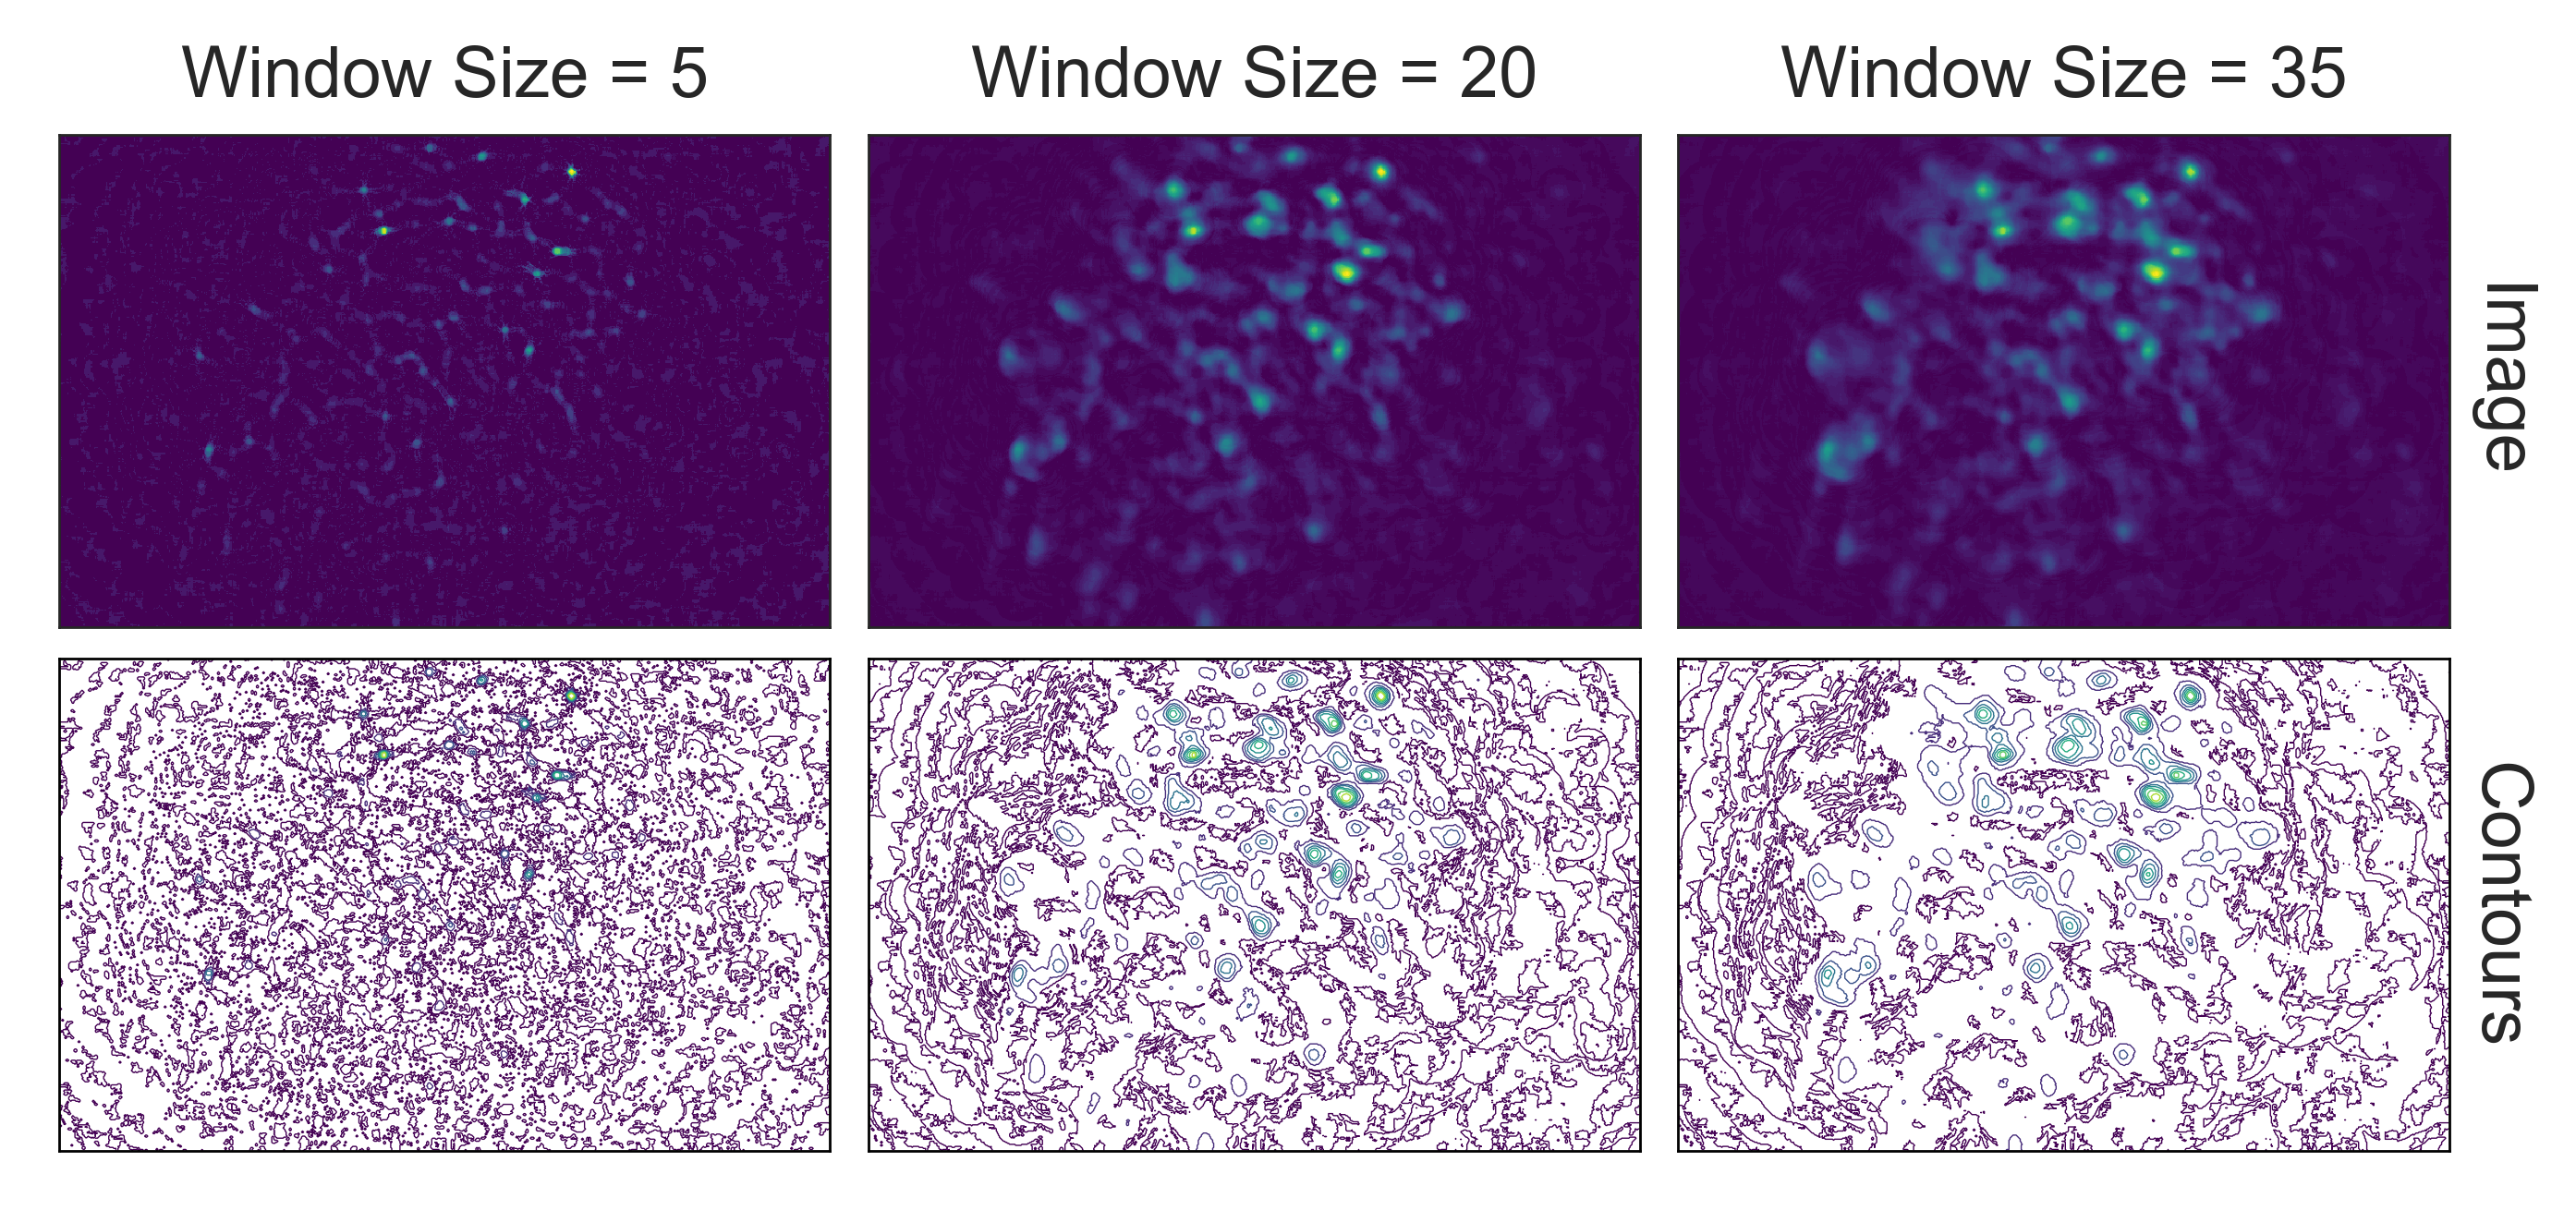

In [15]:
def plt_im(x, plt_type, color, **kwargs):
    plt_type = plt_type.values[0]
    x = x.values[0]
    if plt_type == 'Image':
        im = plt.imshow(x, cmap='viridis', **kwargs)
        ax = im.axes
        ax.invert_yaxis()
    elif plt_type == 'Contours':
        im = plt.contour(x, cmap='viridis', linewidths=0.2, **kwargs)
        ax = im.ax
        ax.set_aspect('equal')
        for sp in ['top', 'bottom', 'left', 'right']:
            ax.spines[sp].set_visible(True)
            ax.spines[sp].set_color('black')
            ax.spines[sp].set_linewidth(0.4)
    ax.margins(0)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return im

grid = sns.FacetGrid(
    de_pd, row='type', col='Window Size',
    margin_titles=True,
    despine=False,
)
aspect = 752*3/480/2
grid.map(plt_im, 'data', 'type')
for ax in grid.axes.flat:
    plt.setp(ax.texts, text="")
grid.set_titles(row_template="{row_name}")
for ax in grid.axes.flat:
    plt.setp(ax.texts, bbox={'alpha': 0})
grid.fig.set_dpi(500)
grid.fig.set_size_inches((5.51, 5.51/aspect))
grid.fig.subplots_adjust(hspace=0.05, wspace=0.05)
grid.savefig("./figs/back_rm_params.svg")
grid.savefig("./figs/back_rm_params.png")
grid.savefig("./figs/back_rm_params.tiff")

# initialization

## load in from disk

In [16]:
%%time
minian = open_minian(dpath,
                     fname=param_save_minian['fname'],
                     backend=param_save_minian['backend'])

CPU times: user 101 ms, sys: 34.7 ms, total: 136 ms
Wall time: 195 ms


In [17]:
Y = minian['Y'].astype(np.float)
max_proj = Y.max('frame').compute()
Y_flt = Y.stack(spatial=['height', 'width'])

## generating over-complete set of seeds

In [18]:
%%time
seeds = seeds_init(Y, **param_seeds_init)

constructing chunks
creating parallel scheme
computing max projections
calculating local maximum
CPU times: user 8.65 s, sys: 851 ms, total: 9.5 s
Wall time: 2.7 s


In [ ]:
hv.output(size=output_size)
visualize_seeds(max_proj, seeds)

## gaussian-mixture-model refine

In [19]:
%%time
seeds, pv, gmm= gmm_refine(Y_flt, seeds, **param_gmm_refine)

selecting seeds
computing peak-valley values
[########################################] | 100% Completed |  3.0s
fitting GMM models
CPU times: user 11.1 s, sys: 2.66 s, total: 13.8 s
Wall time: 3.15 s


## peak-noise-ratio refine

In [ ]:
%%time
if interactive:
    noise_freq_list = [0.005, 0.01, 0.02, 0.06, 0.1, 0.2, 0.3, 0.45]
    example_seeds = seeds.loc[[1426, 1549, 1083, 1235, 100, 1016]]
    # example_seeds = seeds.sample(6, axis='rows')
    example_trace = (Y_flt
                     .sel(spatial=[tuple(hw) for hw in example_seeds[['height', 'width']].values])
                     .assign_coords(spatial=np.arange(6))
                     .rename(dict(spatial='seed')))
    smooth_dict = dict()
    for freq in noise_freq_list:
        trace_smth_low = smooth_sig(example_trace, freq)
        trace_smth_high = smooth_sig(example_trace, freq, btype='high')
        trace_smth_low = trace_smth_low.compute()
        trace_smth_high = trace_smth_high.compute()
        hv_trace = hv.HoloMap({
            'signal': (hv.Dataset(trace_smth_low)
                       .to(hv.Curve, kdims=['frame'])
                       .opts(frame_width=300, aspect=2, xlabel='Frame', ylabel='Signal (A.U.)')),
            'noise': (hv.Dataset(trace_smth_high)
                      .to(hv.Curve, kdims=['frame'])
                      .opts(frame_width=300, aspect=2, xlabel='Frame', ylabel='Signal (A.U.)'))
        }, kdims='trace').collate()
        smooth_dict[freq] = hv_trace

## capture pnr refine

In [ ]:
hv.output(size=120)
if interactive:
    hv_res = (hv.HoloMap(smooth_dict, kdims=['noise_freq']).collate().opts(aspect=2)
              .overlay('trace').layout('seed').cols(2))
    display(hv_res)

## generate pnr refine params

In [20]:
%%time
noise_freq_list = [0.1/15, 1/15, 7/15]
example_seeds = seeds.loc[[1426, 100, 1016]]
example_trace = (
    Y_flt.sel(
        spatial=[tuple(hw) for hw in example_seeds[['height', 'width']].values],
        frame=slice(13000, 23000)
    )
    .assign_coords(spatial=np.arange(3))
    .rename(dict(spatial='Seed ID')))
df_list = []
for freq in noise_freq_list:
    str_freq = '{:.1f} Hz'.format(15 * freq)
    trace_smth_low = smooth_sig(example_trace, freq).compute()
    trace_smth_high = smooth_sig(example_trace, freq, btype='high').compute()
    df_low = trace_smth_low.to_dataframe().reset_index()
    df_high = trace_smth_high.to_dataframe().reset_index()
    df_low['sig'] = "Signal"
    df_low['Noise Frequency'] = str_freq
    df_high['sig'] = "Noise"
    df_high['Noise Frequency'] = str_freq
    df_list.append(df_low)
    df_list.append(df_high)
re_df = pd.concat(df_list, ignore_index=True).rename({'Y': 'Signal (A.U.)', 'frame': 'Frame'}, axis='columns')

CPU times: user 9.56 s, sys: 2.93 s, total: 12.5 s
Wall time: 3.23 s


/opt/miniconda3/envs/minian_paper_data/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/miniconda3/envs/minian_paper_data/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/miniconda3/envs/minian_paper_data/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywor

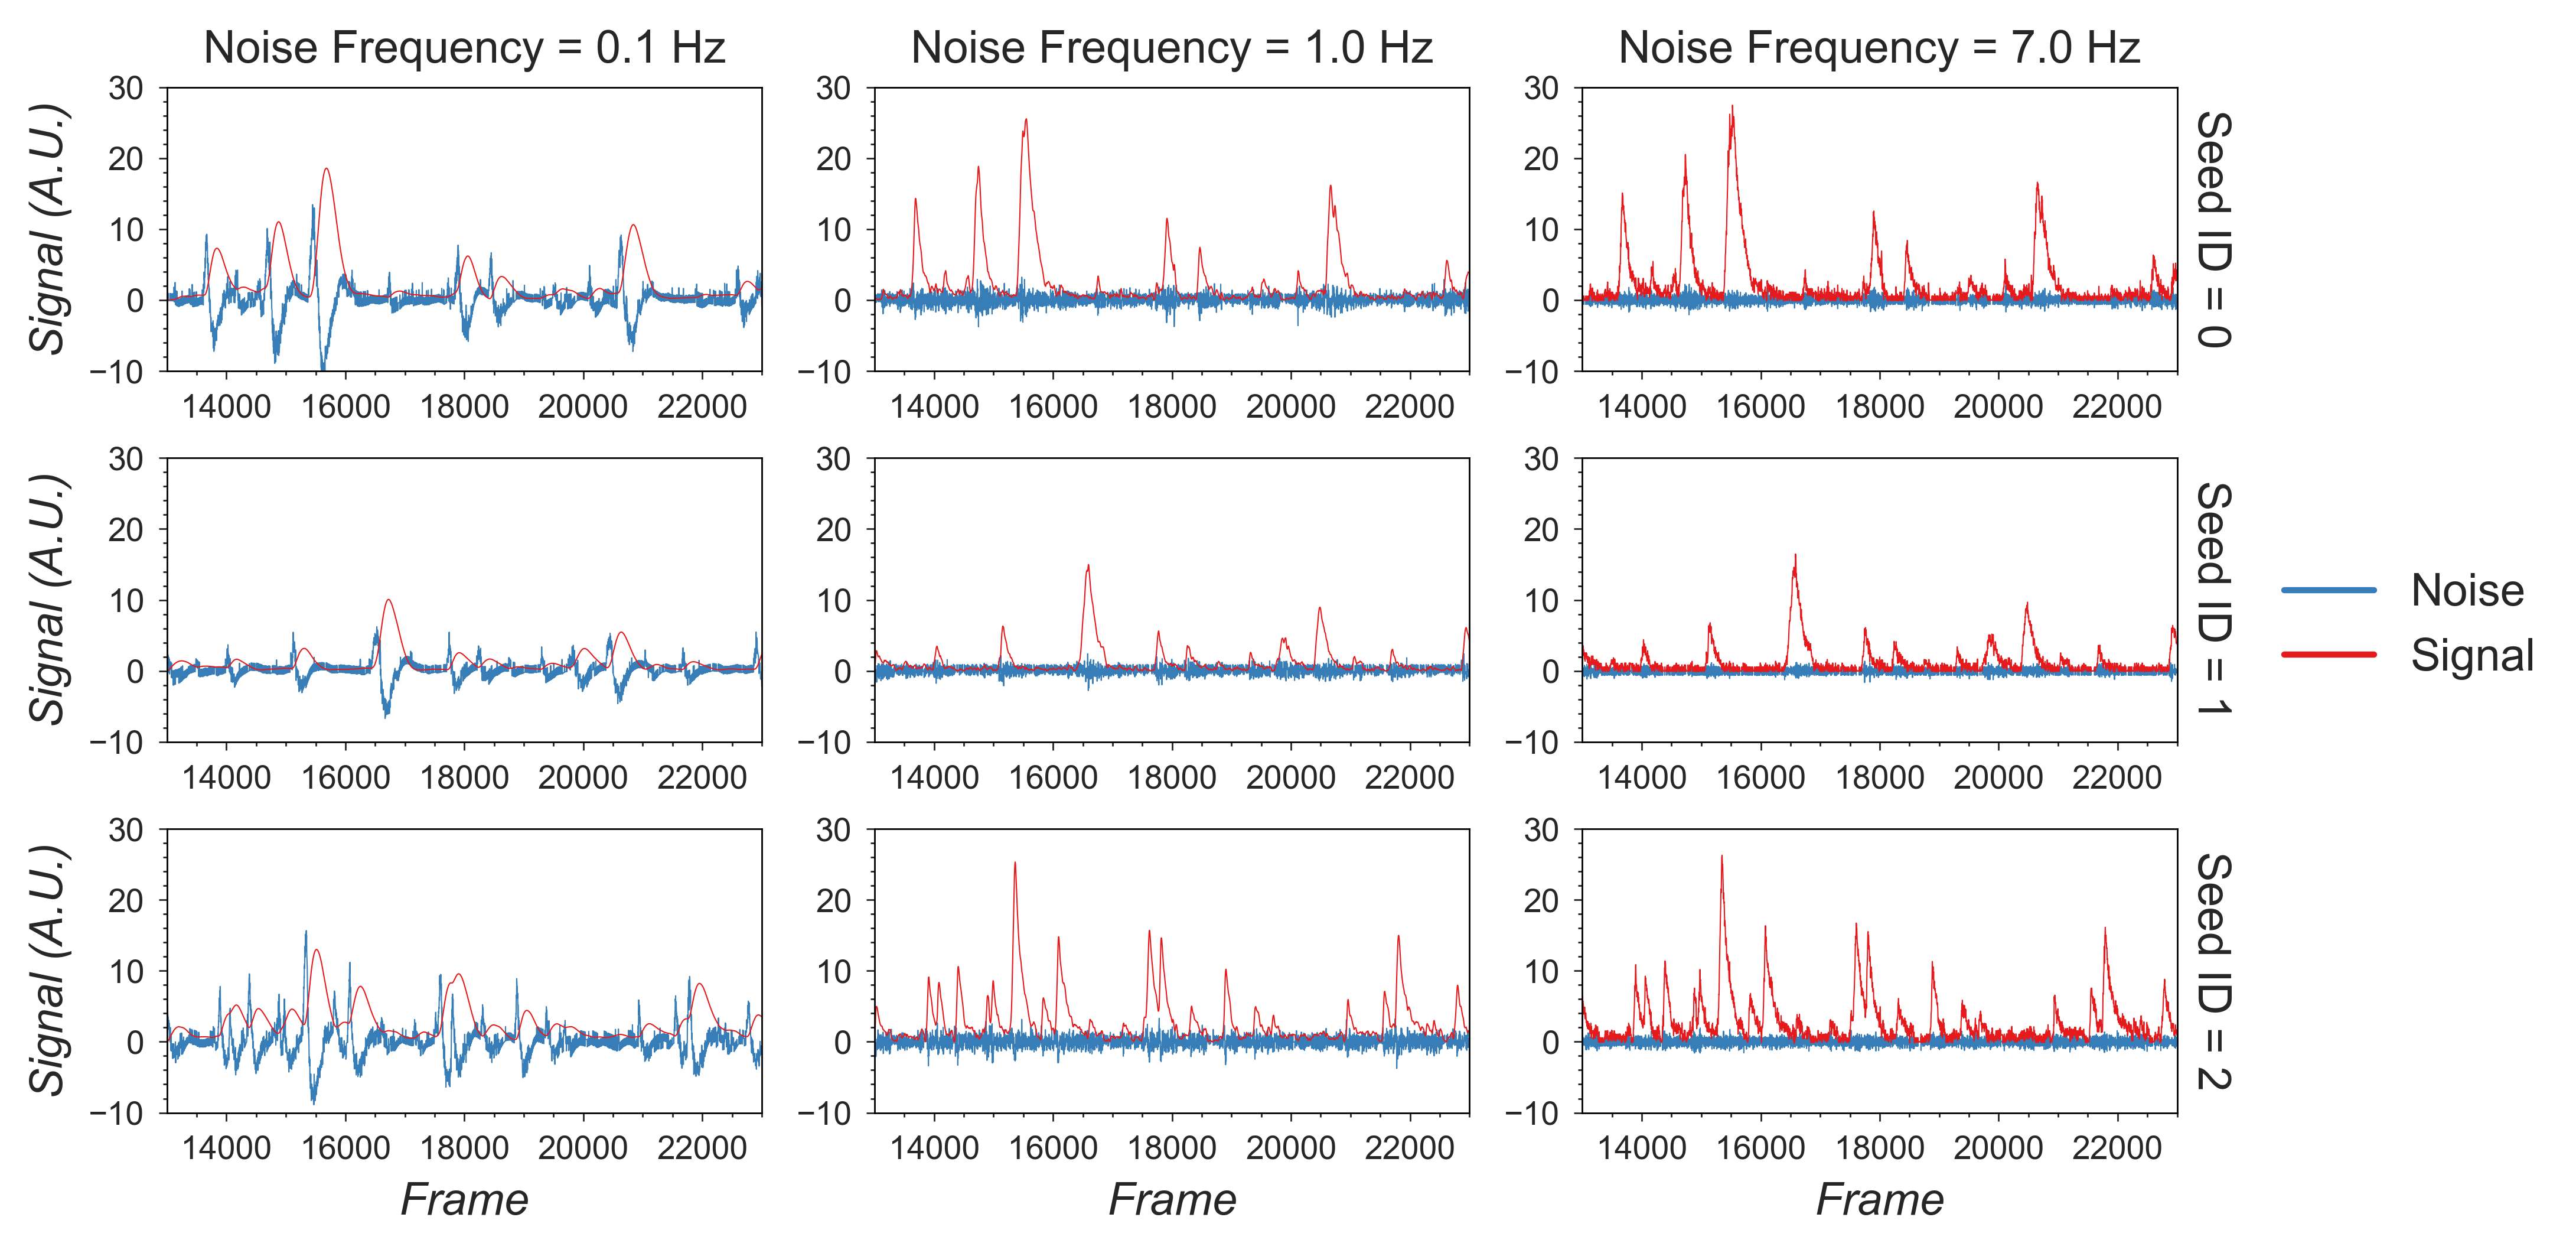

In [21]:
from bokeh.palettes import Set1_9

def lp(x, y, hue, color, xlim, ylim, **kwargs):
    ax = sns.lineplot(
        x, y, hue, **kwargs)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(ax.get_xlabel(), fontstyle='italic')
    ax.set_ylabel(ax.get_ylabel(), fontstyle='italic')
    for sp in ['top', 'bottom', 'left', 'right']:
        ax.spines[sp].set_visible(True)
        ax.spines[sp].set_color('black')
        ax.spines[sp].set_linewidth(0.4)
    return ax

grid = sns.FacetGrid(
    re_df, row='Seed ID', col='Noise Frequency',
    margin_titles=True,
    sharex=False, sharey=False,
    legend_out=True,
    despine=True,
)
grid.map(
    lp, 'Frame', 'Signal (A.U.)', 'sig',
    palette={'Noise': Set1_9[1], 'Signal': Set1_9[0]},
    linewidth=0.3,
    legend='brief',
    xlim=((13000, 23000)),
    ylim=((-10, 30)),
    hue_order=('Noise', 'Signal'),
)
for ax in grid.axes.flat:
    plt.setp(ax.texts, bbox={'alpha': 0})
aspect = 1.8
grid.fig.set_dpi(500)
grid.fig.set_size_inches((7.87, 7.87/aspect))
grid.fig.tight_layout(h_pad=0.5, w_pad=0.8)
grid.add_legend()
# grid._legend.texts[0].set_text('')
grid.savefig("./figs/pnr_params.svg")
grid.savefig("./figs/pnr_params.png")
grid.savefig("./figs/pnr_params.tiff")

# CNMF

## loading data

In [22]:
%%time
minian = open_minian(dpath,
                     fname=param_save_minian['fname'],
                     backend=param_save_minian['backend'])
# minian = minian.sel(height=slice(240*0.15, 240*0.85), width=slice(376*0.15, 376*0.85))
Y = minian['Y'].astype(float)
A_init = minian['A_init'].rename(unit_id_init='unit_id')
usub = (A_init.sum(['height', 'width']) > 0).compute()
A_init = A_init.where(usub, drop=True)
C_init = minian['C_init'].rename(unit_id_init='unit_id')
C_init = C_init.where(usub, drop=True)
b_init = minian['b_init']
f_init = minian['f_init']

CPU times: user 1.72 s, sys: 453 ms, total: 2.17 s
Wall time: 466 ms


## estimate spatial noise

In [23]:
%%time
sn_spatial = get_noise_fft(Y, **param_get_noise).persist()

[########################################] | 100% Completed | 20.2s
CPU times: user 1min 55s, sys: 7.59 s, total: 2min 2s
Wall time: 20.2 s


## test parameters for spatial update

In [ ]:
A_sub = A_init.persist()
C_sub = C_init.persist()

In [24]:
if interactive:
    # units = np.random.choice(A_init.coords['unit_id'], 10, replace=False)
    units = [76,  115,  262,  263,  279,  704,  732,  791, 1000, 1247]
    units.sort()
    A_sub = A_init.sel(unit_id=units).persist()
    C_sub = C_init.sel(unit_id=units).persist()

In [25]:
%%time
if interactive:
    sprs_ls = [0.01, 0.1, 0.4]
    A_dict = dict()
    C_dict = dict()
    for cur_sprs in sprs_ls:
        cur_A, cur_b, cur_C, cur_f = update_spatial(
            Y, A_sub, b_init, C_sub, f_init,
            sn_spatial, dl_wnd=param_first_spatial['dl_wnd'], sparse_penal=cur_sprs)
        if cur_A.sizes['unit_id']:
            A_dict[cur_sprs] = cur_A.compute()
            C_dict[cur_sprs] = cur_C.compute()
    hv_res = visualize_spatial_update(A_dict, C_dict, kdims=['sparse penalty'])

estimating penalty parameter
computing subsetting matrix
fitting spatial matrix
[########################################] | 100% Completed | 27.4s
removing empty units
updating background
[########################################] | 100% Completed |  5.0s
normalizing result
estimating penalty parameter
computing subsetting matrix
fitting spatial matrix
[########################################] | 100% Completed | 24.6s
removing empty units
updating background
background terms are empty
normalizing result
estimating penalty parameter
computing subsetting matrix
fitting spatial matrix
[########################################] | 100% Completed | 25.7s
removing empty units
updating background
background terms are empty
normalizing result
CPU times: user 4min 54s, sys: 10min 55s, total: 15min 49s
Wall time: 1min 28s


In [ ]:
from minian.visualization import normalize, centroid
def visualize_spatial_update(
        A_dict, C_dict, kdims=None,
        norm=True, datashading=True):
    if not kdims:
        A_dict = dict(dummy=A_dict)
        C_dict = dict(dummy=C_dict)
    hv_pts_dict, hv_A_dict, hv_Ab_dict, hv_C_dict = (
        dict(), dict(), dict(), dict())
    for key, A in A_dict.items():
        A = A.compute()
        C = C_dict[key]
        if norm:
            C = xr.apply_ufunc(
                normalize,
                C.chunk(dict(frame=-1)),
                input_core_dims=[['frame']],
                output_core_dims=[['frame']],
                vectorize=True,
                dask='parallelized',
                output_dtypes=[C.dtype])
        C = C.compute()
        h, w = A.sizes['height'], A.sizes['width']
        cents_df = centroid(A)
        hv_pts_dict[key] = (hv.Points(cents_df,
                                      kdims=['width', 'height'],
                                      vdims=['unit_id'])
                            .opts(plot=dict(tools=['hover']),
                                  style=dict(fill_alpha=0.2,
                                             line_alpha=0, size=8)))
        hv_A_dict[key] = hv.Image(A.sum('unit_id').rename('A'),
                                  kdims=['width', 'height']).opts(xlabel='Width (px)', ylabel='Height (px)')
        hv_Ab_dict[key] = hv.Image((A > 0).sum('unit_id').rename('A_bin'),
                                   kdims=['width', 'height']).opts(xlabel='Width (px)', ylabel='Height (px)')
        hv_C_dict[key] = hv.Dataset(C.rename('C')).to(hv.Curve, kdims='frame')
    hv_pts = hv.HoloMap(hv_pts_dict, kdims=kdims)
    hv_A = hv.HoloMap(hv_A_dict, kdims=kdims)
    hv_Ab = hv.HoloMap(hv_Ab_dict, kdims=kdims)
    hv_C = (hv.HoloMap(hv_C_dict, kdims=kdims).collate()
            .grid('unit_id').redim.label(unit_id='Cell ID').add_dimension('Time', 0, 0))
    if datashading:
        hv_A = regrid(hv_A, height=1, width=1)
        hv_Ab = regrid(hv_Ab, height=1, width=1)
        hv_C = datashade(hv_C)
    hv_A = hv_A.opts(frame_width=400, aspect=w/h,
                     colorbar=True, cmap='viridis')
    hv_Ab = hv_Ab.opts(frame_width=400, aspect=w/h,
                       colorbar=True, cmap='viridis')
    hv_C = hv_C.map(
        lambda cr: cr.opts(frame_width=500, frame_height=50),
        hv.RGB if datashading else hv.Curve)
    return (hv.NdLayout({
        'Pseudo-colored': (hv_pts * hv_A),
        'Binary': (hv_pts * hv_Ab)}, kdims='Spatial Matrix').cols(1)
            + hv_C.relabel('Temporal Components'))
hv_res = visualize_spatial_update(A_dict, C_dict, kdims=['sparse_penalty'])

In [ ]:
hv.output(size=80)
if interactive:
    display(hv_res)

In [26]:
re_ls = []
for sps, cur_A in A_dict.items():
    Asum = cur_A.sum('unit_id').rename('A').compute().values
    Absum = (cur_A.sum('unit_id') > 0).rename('A').compute().values
    Asum = pd.Series({
        'type': 'Spatial Matrix',
        'Sparse Penalty': sps,
        'A': Asum
    })
    Absum = pd.Series({
        'type': 'Binary Spatial Matrix',
        'Sparse Penalty': sps,
        'A': Absum
    })
    re_ls.extend([Asum, Absum])
re_df = pd.concat(re_ls, axis='columns', ignore_index=True).T

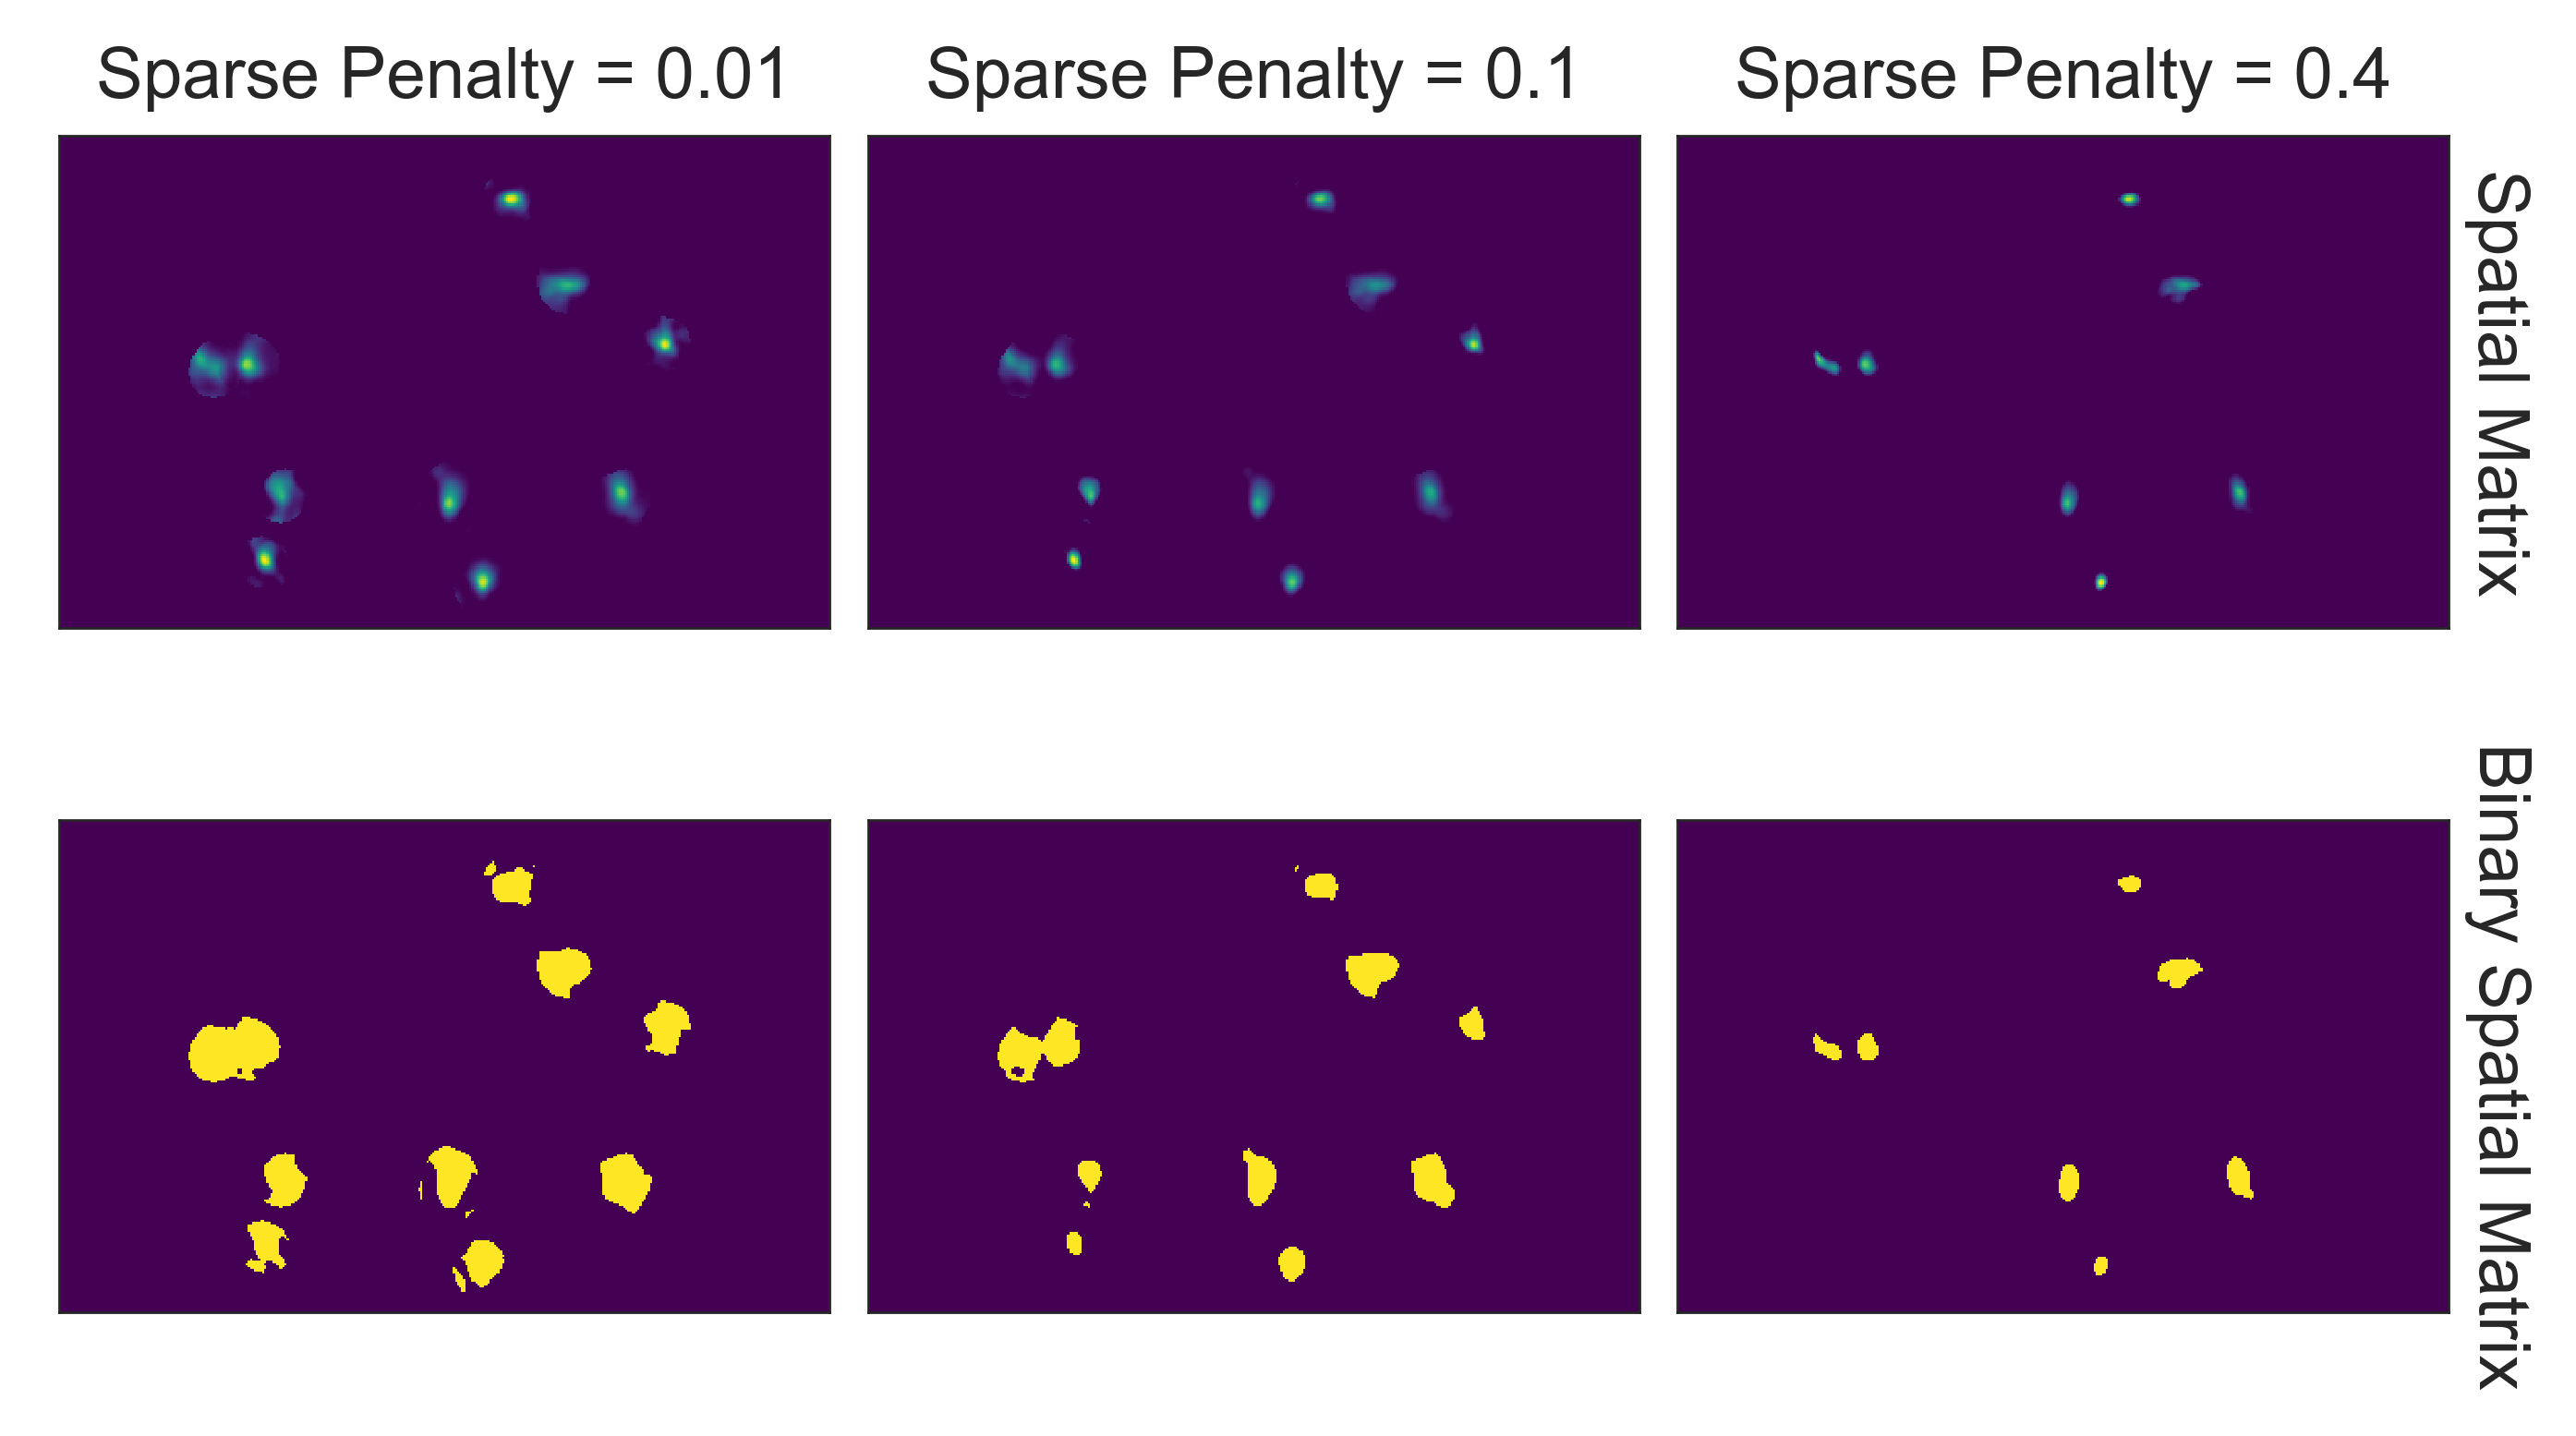

In [27]:
def plt_im(x, color, **kwargs):
    x = x.values[0]
    im = plt.imshow(x, cmap='viridis', **kwargs)
    ax = im.axes
    ax.invert_yaxis()
    ax.margins(0)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return im

grid = sns.FacetGrid(
    re_df, row='type', col='Sparse Penalty',
    margin_titles=True,
    despine=False,
)
aspect = 1.8
grid.map(plt_im, 'A')
for ax in grid.axes.flat:
    plt.setp(ax.texts, text="")
grid.set_titles(row_template="{row_name}")
for ax in grid.axes.flat:
    plt.setp(ax.texts, bbox={'alpha': 0})
grid.fig.set_dpi(500)
grid.fig.set_size_inches((5.51, 5.51/aspect))
grid.fig.subplots_adjust(hspace=0.05, wspace=0.05)
grid.savefig("./figs/spatial_params.svg")
grid.savefig("./figs/spatial_params.png")
grid.savefig("./figs/spatial_params.tiff")

## first spatial update

In [28]:
%%time
A_spatial, b_spatial, C_spatial, f_spatial = update_spatial(
    Y, A_init.persist(), b_init, C_init.persist(), f_init, sn_spatial, **param_first_spatial)

estimating penalty parameter
computing subsetting matrix
[########################################] | 100% Completed | 36.6s
fitting spatial matrix
[########################################] | 100% Completed |  3min  2.7s
removing empty units
post-hoc scaling
[########################################] | 100% Completed |  2.2s
normalizing result
CPU times: user 13min 16s, sys: 18min 46s, total: 32min 3s
Wall time: 3min 55s


In [ ]:
hv.output(size=output_size)
opts = dict(plot=dict(height=A_init.sizes['height'], width=A_init.sizes['width'], colorbar=True), style=dict(cmap='Viridis'))
(regrid(hv.Image(A_init.sum('unit_id').compute().rename('A'), kdims=['width', 'height'])).opts(**opts).relabel("Spatial Footprints Initial")
+ regrid(hv.Image((A_init.fillna(0) > 0).sum('unit_id').compute().rename('A'), kdims=['width', 'height']), aggregator='max').opts(**opts).relabel("Binary Spatial Footprints Initial")
+ regrid(hv.Image(A_spatial.sum('unit_id').compute().rename('A'), kdims=['width', 'height'])).opts(**opts).relabel("Spatial Footprints First Update")
+ regrid(hv.Image((A_spatial > 0).sum('unit_id').compute().rename('A'), kdims=['width', 'height']), aggregator='max').opts(**opts).relabel("Binary Spatial Footprints First Update")).cols(2)

In [ ]:
hv.output(size=output_size)
opts_im = dict(plot=dict(height=b_init.sizes['height'], width=b_init.sizes['width'], colorbar=True), style=dict(cmap='Viridis'))
opts_cr = dict(plot=dict(height=b_init.sizes['height'], width=b_init.sizes['height'] * 2))
(regrid(hv.Image(b_init, kdims=['width', 'height'])).opts(**opts_im).relabel('Background Spatial Initial')
 + datashade(hv.Curve(f_init, kdims=['frame'])).opts(**opts_cr).relabel('Background Temporal Initial')
 + regrid(hv.Image(b_spatial, kdims=['width', 'height'])).opts(**opts_im).relabel('Background Spatial First Update')
 + datashade(hv.Curve(f_spatial, kdims=['frame'])).opts(**opts_cr).relabel('Background Temporal First Update')
).cols(2)

## test parameters for temporal update

In [29]:
if interactive:
    # units = np.random.choice(A_spatial.coords['unit_id'], 20, replace=False)
    units = [264, 1109, 1350]
    units.sort()
    A_sub = A_spatial.sel(unit_id=units).persist()
    C_sub = C_spatial.sel(unit_id=units).persist()

In [30]:
%%time
if interactive:
    p_ls = [1]
    sprs_ls = [0.0002, 0.008, 0.05]
    add_ls = [20]
    noise_ls = [0.06]
    YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict = [dict() for _ in range(6)]
    YrA = compute_trace(Y, A_sub, b_spatial, C_sub, f_spatial).persist()
    for cur_p, cur_sprs, cur_add, cur_noise in itt.product(p_ls, sprs_ls, add_ls, noise_ls):
        ks = (cur_p, cur_sprs, cur_add, cur_noise)
        print("p:{}, sparse penalty:{}, additional lag:{}, noise frequency:{}"
              .format(cur_p, cur_sprs, cur_add, cur_noise))
        YrA, cur_C, cur_S, cur_B, cur_C0, cur_sig, cur_g, cur_scal = update_temporal(
            Y, A_sub, b_spatial, C_sub, f_spatial, sn_spatial, YrA=YrA,
            sparse_penal=cur_sprs, p=cur_p, use_spatial=False, use_smooth=True,
            add_lag = cur_add, noise_freq=cur_noise)
        cur_A = A_spatial.sel(unit_id = cur_C.coords['unit_id'])
        ks = cur_sprs
        YA_dict[ks], C_dict[ks], S_dict[ks], g_dict[ks], sig_dict[ks], A_dict[ks] = (
            YrA, cur_C, cur_S, cur_g, cur_sig, cur_A)

[########################################] | 100% Completed | 11.1s
p:1, sparse penalty:0.0002, additional lag:20, noise frequency:0.06
grouping overlaping units
normalizing traces
smoothing signals
estimating AR coefficients
updating isolated temporal components
[########################################] | 100% Completed |  2.9s
updating overlapping temporal components
0 units dropped due to poor fit:
 []
post-hoc scaling
p:1, sparse penalty:0.008, additional lag:20, noise frequency:0.06
grouping overlaping units
normalizing traces
smoothing signals
estimating AR coefficients
updating isolated temporal components
[########################################] | 100% Completed |  2.9s
updating overlapping temporal components
0 units dropped due to poor fit:
 []
post-hoc scaling
p:1, sparse penalty:0.05, additional lag:20, noise frequency:0.06
grouping overlaping units
normalizing traces
smoothing signals
estimating AR coefficients
updating isolated temporal components
[####################

In [31]:
from minian.visualization import convolve_G, normalize

def datashade_ndcurve(ovly, kdim=None, spread=False):
    if not kdim:
        kdim = ovly.kdims[0].name
    var = np.unique(ovly.dimension_values(kdim)).tolist()
    # color_key = [(v, Category10_10[iv]) for iv, v in enumerate(var)]
    color_key = [
        ('Raw Signal', Category10_10[7]),
        ('Fitted Calcium Trace', Category10_10[1]),
        ('Fitted Spikes', Category10_10[0]),
        ('Fitted Signal', Category10_10[3]),
    ]
    color_pts = hv.NdOverlay(
        {k: hv.Points([0, 0], label=str(k)).opts(style=dict(color=v)) for k, v in color_key})
    ds_ovly = datashade(
        ovly,
        aggregator=count_cat(kdim),
        color_key=dict(color_key),
        min_alpha=200,
        normalization='linear')
    if spread:
        ds_ovly = dynspread(ds_ovly)
    return ds_ovly * color_pts

def construct_pulse_response(g, length=500):
    s = np.zeros(length)
    s[np.arange(0, length, 1000)] = 1
    c = convolve_G(s, g)
    return s, c

def visualize_temporal_update(YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict, kdims=None, norm=True, datashading=True):
    inputs = [YA_dict, C_dict, S_dict, sig_dict, g_dict]
    if not kdims:
        inputs = [dict(dummy=i) for i in inputs]
        A_dict = dict(dummy=A_dict)
    input_dict = {k: [i[k] for i in inputs] for k in inputs[0].keys()}
    hv_YA, hv_C, hv_S, hv_sig, hv_C_pul, hv_S_pul, hv_A = [dict() for _ in range(7)]
    for k, ins in input_dict.items():
        if norm:
            ins[:-1] = [xr.apply_ufunc(
                normalize, i.chunk(dict(frame=-1, unit_id='auto')),
                input_core_dims=[['frame']],
                output_core_dims=[['frame']],
                vectorize=True,
                dask='parallelized',
                output_dtypes=[i.dtype]
            ) for i in ins[:-1]]
        ins[:] = [i.compute() for i in ins]
        ya, c, s, sig, g = ins
        f_crd = ya.coords['frame']
        pul_crd = f_crd.values[:1000]
        s_pul, c_pul = xr.apply_ufunc(
            construct_pulse_response, g,
            input_core_dims=[['lag']],
            output_core_dims=[['t'], ['t']],
            vectorize=True,
            kwargs=dict(length=len(pul_crd)),
            output_sizes=dict(t=len(pul_crd)))
        s_pul, c_pul = (s_pul.assign_coords(t=pul_crd),
                        c_pul.assign_coords(t=pul_crd))
        if norm:
            c_pul = xr.apply_ufunc(
                normalize, c_pul.chunk(dict(t=-1)),
                input_core_dims=[['t']],
                output_core_dims=[['t']],
                dask='parallelized',
                output_dtypes=[c_pul.dtype]
            )
        pul_range = (
            f_crd.min(),
            int(np.around(f_crd.min() + (f_crd.max() - f_crd.min()) / 2)))
        hv_S_pul[k], hv_C_pul[k] = [
            (hv.Dataset(tr.rename('Signal (A.U.)'))
             .to(hv.Curve, kdims=['t']).opts(xlabel='Frame')) for tr in [s_pul, c_pul]]
        hv_YA[k] = (hv.Dataset(ya.rename('Signal (A.U.)'))
                    .to(hv.Curve, kdims=['frame']))
        if c.sizes['unit_id'] > 0:
            hv_C[k], hv_S[k], hv_sig[k] = [
                (hv.Dataset(tr.rename('Signal (A.U.)'))
                 .to(hv.Curve, kdims=['frame'])) for tr in [c, s, sig]]
        hv_A[k] = (hv.Dataset(A_dict[k].rename('A'))
                   .to(hv.Image, kdims=['width', 'height'])
                   .opts(xlabel='Width (px)', ylabel='Height (px)')
                  )
        h, w = A_dict[k].sizes['height'], A_dict[k].sizes['width']
    hvobjs = [hv_YA, hv_C, hv_S, hv_sig, hv_C_pul, hv_S_pul, hv_A]
    hvobjs[:] = [hv.HoloMap(hvobj, kdims=kdims).collate() for hvobj in hvobjs]
    hv_unit = {'Raw Signal': hvobjs[0], 'Fitted Calcium Trace': hvobjs[1],
               'Fitted Spikes': hvobjs[2], 'Fitted Signal': hvobjs[3]}
    hv_pul = {'Simulated Calcium': hvobjs[4].opts(color=Category10_10[1]), 'Simulated Spike': hvobjs[5].opts(color=Category10_10[0])}
    hv_unit = hv.HoloMap(hv_unit, kdims='traces').collate().opts(line_width=20).overlay('traces')
    hv_pul = hv.HoloMap(hv_pul, kdims='traces').collate().overlay('traces')
    hv_A = hvobjs[6]
    if datashading:
        hv_unit = datashade_ndcurve(hv_unit, 'traces')
        hv_A = regrid(hv_A)
    else:
        hv_unit = Dynamic(hv_unit)
        hv_A = Dynamic(hv_A)
    hv_pul = Dynamic(hv_pul)
    hv_unit = hv_unit.map(
        lambda p: p.opts(plot=dict(frame_height=400, frame_width=1000, xlabel='Frame')))
    hv_pul = (hv_pul.opts(plot=dict(frame_width=500, aspect=w/h))
              .redim(t=hv.Dimension('t', soft_range=pul_range)))
    hv_A = hv_A.opts(plot=dict(frame_width=500, aspect=w/h), style=dict(cmap='Viridis'))
    return (hv_unit.relabel("Current Unit: Temporal Traces")
            + hv.NdLayout({
                'Simulated Pulse Response': hv_pul,
                'Spatial Footprint': hv_A}, kdims='Current Unit')).cols(1)

## capture temporal update

In [ ]:
hv.output(size=80)
hv_res = visualize_temporal_update(
    YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict,
    kdims=['sparse_penalty'])
hv_res

## temporal update params

In [32]:
re_dict = {sps: (ya, S_dict[sps], C_dict[sps]) for sps, ya in YA_dict.items()}
re_ls = []
for sps, (ya, s, c) in re_dict.items():
    ya = xr.apply_ufunc(
        normalize, ya.compute(),
        input_core_dims=[['frame']],
        output_core_dims=[['frame']],
        vectorize=True,
    )
    s = xr.apply_ufunc(
        normalize, s.compute(),
        input_core_dims=[['frame']],
        output_core_dims=[['frame']],
        vectorize=True,
    )
    c = xr.apply_ufunc(
        normalize, c.compute(),
        input_core_dims=[['frame']],
        output_core_dims=[['frame']],
        vectorize=True,
    )
    ya = ya.rename('Signal (A.U.)').to_dataframe().reset_index()
    s = s.rename('Signal (A.U.)').to_dataframe().reset_index()
    c = c.rename('Signal (A.U.)').to_dataframe().reset_index()
    ya['sig'] = 'Raw Signal'
    ya['Sparse Penalty'] = sps
    s['sig'] = 'Fitted Spikes'
    s['Sparse Penalty'] = sps
    c['sig'] = 'Fitted Calcium'
    c['Sparse Penalty'] = sps
    re_ls.extend([ya, s, c])
re_df = pd.concat(re_ls, ignore_index=True).rename({'frame': 'Frame', 'unit_id': 'Cell ID'}, axis='columns')

/opt/miniconda3/envs/minian_paper_data/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue, size. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/miniconda3/envs/minian_paper_data/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue, size. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/miniconda3/envs/minian_paper_data/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue, size. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without 

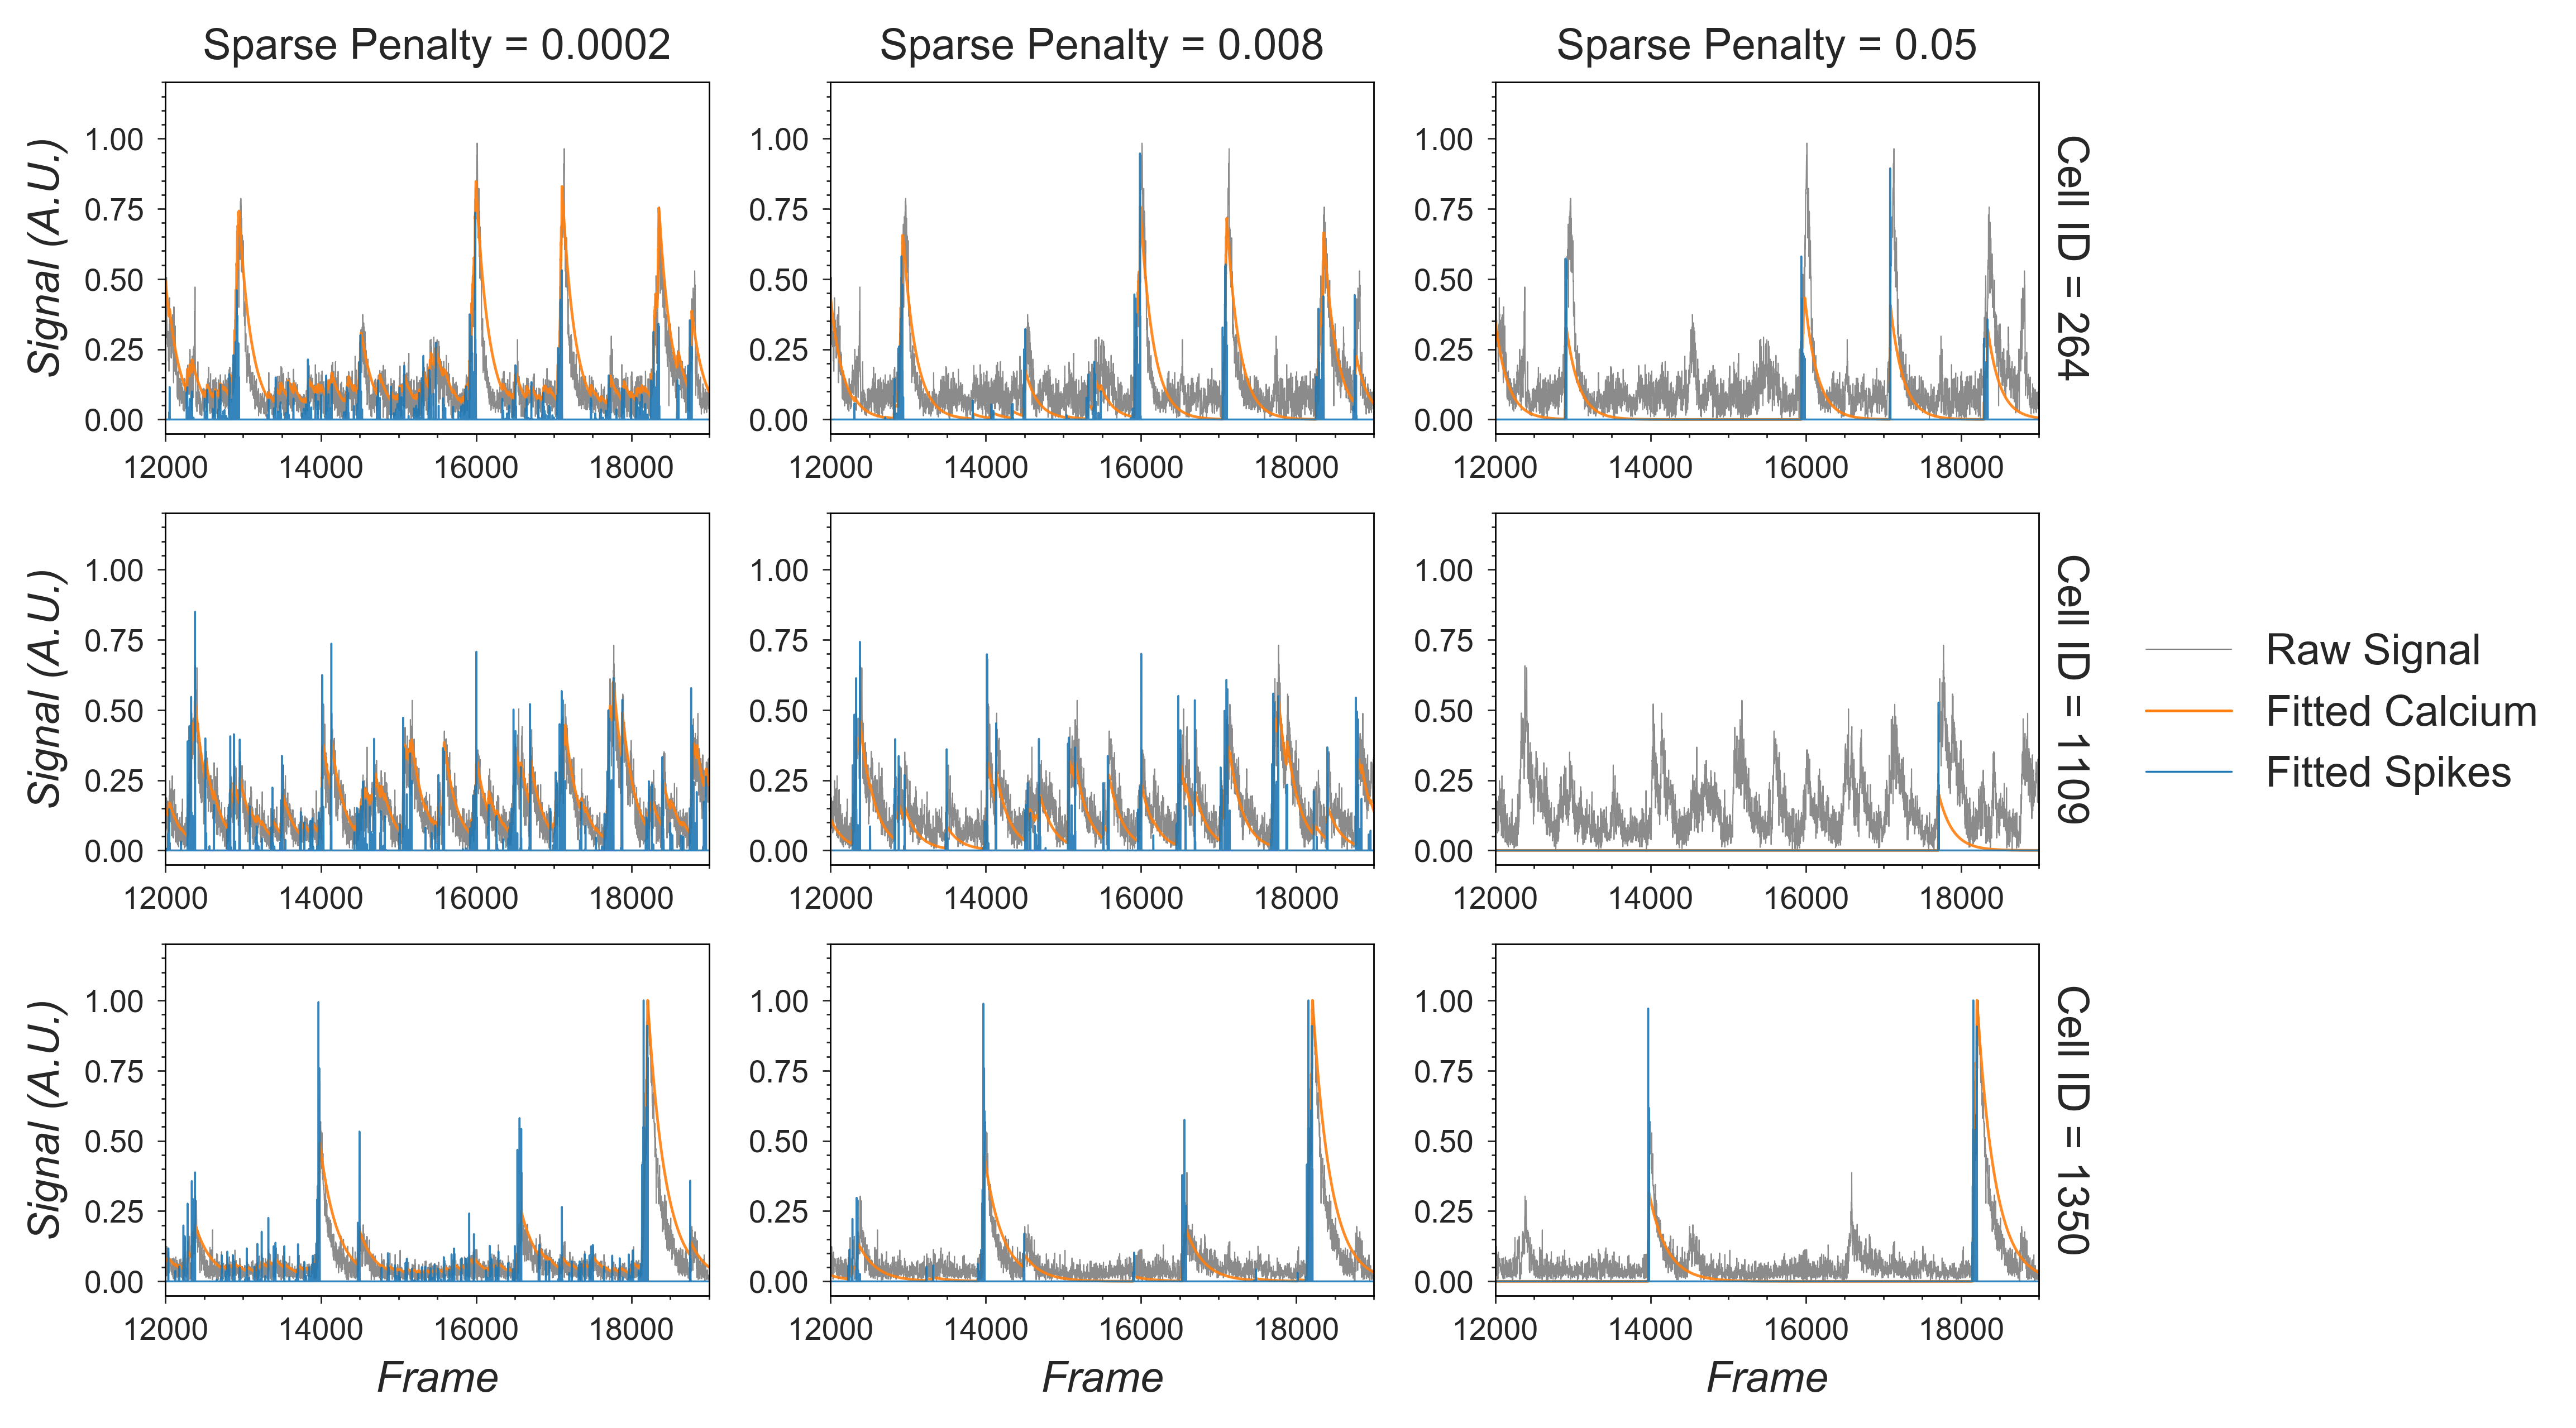

In [33]:
from bokeh.palettes import Category10_10

def lp(x, y, hue, size=None, color=None, xlim=None, ylim=None, **kwargs):
    ax = sns.lineplot(
        x, y, hue, size, alpha=0.9, **kwargs)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(ax.get_xlabel(), fontstyle='italic')
    ax.set_ylabel(ax.get_ylabel(), fontstyle='italic')
    for sp in ['top', 'bottom', 'left', 'right']:
        ax.spines[sp].set_visible(True)
        ax.spines[sp].set_color('black')
        ax.spines[sp].set_linewidth(0.4)
    return ax

grid = sns.FacetGrid(
    re_df, row='Cell ID', col='Sparse Penalty',
    margin_titles=True,
    sharex=False, sharey=False,
    legend_out=True,
    despine=True,
)
grid.map(
    lp, 'Frame', 'Signal (A.U.)', 'sig', 'sig',
    palette={'Raw Signal': Category10_10[7], 'Fitted Spikes': Category10_10[0], 'Fitted Calcium': Category10_10[1]},
    sizes={'Raw Signal': 0.3, 'Fitted Spikes': 0.5, 'Fitted Calcium': 0.7},
    # linewidth=0.4,
    legend='brief',
    xlim=((12000, 19000)),
    ylim=((-0.05, 1.2)),
    hue_order=('Raw Signal', 'Fitted Calcium', 'Fitted Spikes',),
)
for ax in grid.axes.flat:
    plt.setp(ax.texts, bbox={'alpha': 0})
aspect = 1.5
grid.fig.set_dpi(500)
grid.fig.set_size_inches((7.87, 7.87/aspect))
grid.fig.tight_layout(h_pad=0.7, w_pad=1)
grid.add_legend()
# grid._legend.texts[0].set_text('')
grid.savefig("./figs/temporal_params.svg")
grid.savefig("./figs/temporal_params.png")
grid.savefig("./figs/temporal_params.tiff")

## first temporal update

In [ ]:
%%time
YrA, C_temporal, S_temporal, B_temporal, C0_temporal, sig_temporal, g_temporal, scale = update_temporal(
    Y, A_spatial, b_spatial, C_spatial, f_spatial, sn_spatial, **param_first_temporal)
A_temporal = A_spatial.sel(unit_id = C_temporal.coords['unit_id'])

In [ ]:
hv.output(size=output_size)
opts_im = dict(frame_width=500, aspect=2, colorbar=True, cmap='Viridis', logz=True)
(regrid(hv.Image(C_init.rename('ci'), kdims=['frame', 'unit_id'])).opts(**opts_im).relabel("Temporal Trace Initial")
 + hv.Div('')
 + regrid(hv.Image(C_temporal.rename('c1'), kdims=['frame', 'unit_id'])).opts(**opts_im).relabel("Temporal Trace First Update")
 + regrid(hv.Image(S_temporal.rename('s1'), kdims=['frame', 'unit_id'])).opts(**opts_im).relabel("Spikes First Update")
).cols(2)

In [ ]:
hv.output(size=output_size)
if interactive:
    h, w = A_spatial.sizes['height'], A_spatial.sizes['width']
    im_opts = dict(aspect=w/h, frame_width=500, cmap='Viridis')
    cr_opts = dict(aspect=3, frame_width=1000)
    bad_units = list(set(A_spatial.coords['unit_id'].values) - set(A_temporal.coords['unit_id'].values))
    bad_units.sort()
    if len(bad_units)>0:
        hv_res = (hv.NdLayout({
            "Spatial Footprin": regrid(hv.Dataset(A_spatial.sel(unit_id=bad_units).rename('A'))
                                       .to(hv.Image, kdims=['width', 'height'])).opts(**im_opts),
            "Spatial Footprints of Accepted Units": regrid(hv.Image(A_temporal.sum('unit_id').compute().rename('A'), kdims=['width', 'height'])).opts(**im_opts)
        })
                  + datashade(hv.Dataset(YrA.sel(unit_id=bad_units).rename('raw'))
                              .to(hv.Curve, kdims=['frame'])).opts(**cr_opts).relabel("Temporal Trace")).cols(1)
        display(hv_res)
    else:
        print("No rejected units to display")

In [ ]:
hv.output(size=output_size)
if interactive:
    display(visualize_temporal_update(YrA, C_temporal, S_temporal, g_temporal, sig_temporal, A_temporal))

## merge units

In [ ]:
%%time
A_mrg, sig_mrg, add_list = unit_merge(A_temporal, sig_temporal, [S_temporal, C_temporal], **param_first_merge)
S_mrg, C_mrg = add_list[:]

In [ ]:
hv.output(size=output_size)
opts_im = dict(frame_width=500, aspect=2, colorbar=True, cmap='Viridis', logz=True)
(regrid(hv.Image(sig_temporal.rename('c1'), kdims=['frame', 'unit_id'])).relabel("Temporal Signals Before Merge").opts(**opts_im) +
regrid(hv.Image(sig_mrg.rename('c2'), kdims=['frame', 'unit_id'])).relabel("Temporal Signals After Merge").opts(**opts_im))

## test parameters for spatial update

In [ ]:
if interactive:
    units = np.random.choice(A_mrg.coords['unit_id'], 10, replace=False)
    units.sort()
    A_sub = A_mrg.sel(unit_id=units).persist()
    sig_sub = sig_mrg.sel(unit_id=units).persist()

In [ ]:
%%time
if interactive:
    sprs_ls = [0.01, 0.05, 0.1]
    A_dict = dict()
    C_dict = dict()
    for cur_sprs in sprs_ls:
        cur_A, cur_b, cur_C, cur_f = update_spatial(
            Y, A_sub, b_init, sig_sub, f_init,
            sn_spatial, dl_wnd=param_second_spatial['dl_wnd'], sparse_penal=cur_sprs)
        if cur_A.sizes['unit_id']:
            A_dict[cur_sprs] = cur_A
            C_dict[cur_sprs] = cur_C
    hv_res = visualize_spatial_update(A_dict, C_dict, kdims=['sparse penalty'])

In [ ]:
hv.output(size=output_size)
if interactive:
    display(hv_res)

## second spatial update

In [ ]:
%%time
A_spatial_it2, b_spatial_it2, C_spatial_it2, f_spatial_it2 = update_spatial(
    Y, A_mrg, b_spatial, sig_mrg, f_spatial, sn_spatial, **param_second_spatial)

In [ ]:
hv.output(size=output_size)
opts = dict(aspect=A_spatial_it2.sizes['width']/A_spatial_it2.sizes['height'], frame_width=500, colorbar=True, cmap='Viridis')
(regrid(hv.Image(A_mrg.sum('unit_id').compute().rename('A'), kdims=['width', 'height'])).opts(**opts).relabel("Spatial Footprints First Update")
+ regrid(hv.Image((A_mrg.fillna(0) > 0).sum('unit_id').compute().rename('A'), kdims=['width', 'height']), aggregator='max').opts(**opts).relabel("Binary Spatial Footprints First Update")
+ regrid(hv.Image(A_spatial_it2.sum('unit_id').compute().rename('A'), kdims=['width', 'height'])).opts(**opts).relabel("Spatial Footprints Second Update")
+ regrid(hv.Image((A_spatial_it2 > 0).sum('unit_id').compute().rename('A'), kdims=['width', 'height']), aggregator='max').opts(**opts).relabel("Binary Spatial Footprints Second Update")).cols(2)

In [ ]:
hv.output(size=output_size)
opts_im = dict(aspect=b_spatial_it2.sizes['width'] / b_spatial_it2.sizes['height'], frame_width=500, colorbar=True, cmap='Viridis')
opts_cr = dict(aspect=2, frame_height=int(500 * b_spatial_it2.sizes['height'] / b_spatial_it2.sizes['width']))
(regrid(hv.Image(b_spatial, kdims=['width', 'height'])).opts(**opts_im).relabel('Background Spatial First Update')
 + datashade(hv.Curve(f_spatial, kdims=['frame'])).opts(**opts_cr).relabel('Background Temporal First Update')
 + regrid(hv.Image(b_spatial_it2, kdims=['width', 'height'])).opts(**opts_im).relabel('Background Spatial Second Update')
 + datashade(hv.Curve(f_spatial_it2, kdims=['frame'])).opts(**opts_cr).relabel('Background Temporal Second Update')
).cols(2)

## test parameters for temporal update

In [ ]:
if interactive:
    units = np.random.choice(A_spatial_it2.coords['unit_id'], 10, replace=False)
    units.sort()
    A_sub = A_spatial_it2.sel(unit_id=units).persist()
    C_sub = C_spatial_it2.sel(unit_id=units).persist()

In [ ]:
%%time
if interactive:
    p_ls = [1]
    sprs_ls = [0.1, 0.5, 1]
    add_ls = [20]
    noise_ls = [0.06]
    YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict = [dict() for _ in range(6)]
    YrA = compute_trace(Y, A_sub, b_spatial, C_sub, f_spatial).persist()
    for cur_p, cur_sprs, cur_add, cur_noise in itt.product(p_ls, sprs_ls, add_ls, noise_ls):
        ks = (cur_p, cur_sprs, cur_add, cur_noise)
        print("p:{}, sparse penalty:{}, additional lag:{}, noise frequency:{}"
              .format(cur_p, cur_sprs, cur_add, cur_noise))
        YrA, cur_C, cur_S, cur_B, cur_C0, cur_sig, cur_g, cur_scal = update_temporal(
            Y, A_sub, b_spatial, C_sub, f_spatial, sn_spatial, YrA=YrA,
            sparse_penal=cur_sprs, p=cur_p, use_spatial=False, use_smooth=True,
            add_lag = cur_add, noise_freq=cur_noise)
        cur_A = A_spatial_it2.sel(unit_id = cur_C.coords['unit_id'])
        YA_dict[ks], C_dict[ks], S_dict[ks], g_dict[ks], sig_dict[ks], A_dict[ks] = (
            YrA, cur_C, cur_S, cur_g, cur_sig, cur_A)
    hv_res = visualize_temporal_update(
        YA_dict, C_dict, S_dict, g_dict, sig_dict, A_dict,
        kdims=['p', 'sparse penalty', 'additional lag', 'noise frequency'])

In [ ]:
hv.output(size=output_size)
if interactive:
    display(hv_res)

## second temporal update

In [ ]:
%%time
YrA, C_temporal_it2, S_temporal_it2, B_temporal_it2, C0_temporal_it2, sig_temporal_it2, g_temporal_it2, scale_temporal_it2 = update_temporal(
    Y, A_spatial_it2, b_spatial_it2, C_spatial_it2, f_spatial_it2, sn_spatial, **param_second_temporal)
A_temporal_it2 = A_spatial_it2.sel(unit_id=C_temporal_it2.coords['unit_id'])
A_temporal_it2 = rechunk_like(A_temporal_it2, A_spatial_it2)

In [ ]:
hv.output(size=output_size)
opts_im = dict(frame_width=500, aspect=2, colorbar=True, cmap='Viridis', logz=True)
(regrid(hv.Image(C_mrg.rename('c1'), kdims=['frame', 'unit_id'])).opts(**opts_im).relabel("Temporal Trace First Update")
 + regrid(hv.Image(S_mrg.rename('s1'), kdims=['frame', 'unit_id'])).opts(**opts_im).relabel("Spikes First Update")
 + regrid(hv.Image(C_temporal_it2.rename('c2').rename(unit_id='unit_id_it2'), kdims=['frame', 'unit_id_it2'])).opts(**opts_im).relabel("Temporal Trace Second Update")
 + regrid(hv.Image(S_temporal_it2.rename('s2').rename(unit_id='unit_id_it2'), kdims=['frame', 'unit_id_it2'])).opts(**opts_im).relabel("Spikes Second Update")).cols(2)

In [ ]:
hv.output(size=output_size)
if interactive:
    h, w = A_spatial_it2.sizes['height'], A_spatial_it2.sizes['width']
    im_opts = dict(aspect=w/h, frame_width=500, cmap='Viridis')
    cr_opts = dict(aspect=3, frame_width=1000)
    bad_units = list(set(A_spatial_it2.coords['unit_id'].values) - set(A_temporal_it2.coords['unit_id'].values))
    bad_units.sort()
    if len(bad_units)>0:
        hv_res = (hv.NdLayout({
            "Spatial Footprin": regrid(hv.Dataset(A_spatial_it2.sel(unit_id=bad_units).rename('A'))
                                       .to(hv.Image, kdims=['width', 'height'])).opts(**im_opts),
            "Spatial Footprints of Accepted Units": regrid(hv.Image(A_temporal_it2.sum('unit_id').compute().rename('A'), kdims=['width', 'height'])).opts(**im_opts)
        })
                  + datashade(hv.Dataset(YrA.sel(unit_id=bad_units).rename('raw'))
                              .to(hv.Curve, kdims=['frame'])).opts(**cr_opts).relabel("Temporal Trace")).cols(1)
        display(hv_res)
    else:
        print("No rejected units to display")

In [ ]:
hv.output(size=output_size)
if interactive:
    display(visualize_temporal_update(YrA, C_temporal_it2, S_temporal_it2, g_temporal_it2, sig_temporal_it2, A_temporal_it2))

## merge units

In [ ]:
%%time
A_mrg_it2, C_mrg_it2, add_list = unit_merge(A_temporal_it2, C_temporal_it2, [S_temporal_it2, C0_temporal_it2, g_temporal_it2, B_temporal_it2], **param_second_merge)

In [ ]:
hv.output(size=output_size)
opts_im = dict(frame_width=500, aspect=1.5, colorbar=True, cmap='Viridis', logz=True)
(regrid(hv.Image(C_temporal_it2.rename('c'), kdims=['frame', 'unit_id'])).relabel("Temporal Signals Before Merge").opts(**opts_im) +
regrid(hv.Image(C_mrg_it2.rename('c'), kdims=['frame', 'unit_id'])).relabel("Temporal Signals After Merge").opts(**opts_im))

In [ ]:
S_mrg_it2, C0_mrg_it2, g_mrg_it2, B_mrg_it2 = add_list[:]

## save results

In [ ]:
%%time
save_minian(A_temporal_it2.rename('A'), **param_save_minian)
save_minian(C_temporal_it2.rename('C'), **param_save_minian)
save_minian(S_temporal_it2.rename('S'), **param_save_minian)
save_minian(g_temporal_it2.rename('g'), **param_save_minian)
save_minian(C0_temporal_it2.rename('C0'), **param_save_minian)
save_minian(B_temporal_it2.rename('B'), **param_save_minian)
save_minian(b_spatial_it2.rename('b'), **param_save_minian)
save_minian(f_spatial_it2.rename('f'), **param_save_minian)

## visualization

In [ ]:
minian = open_minian(dpath,
                     fname=param_save_minian['fname'],
                     backend=param_save_minian['backend'])
varr = load_videos(dpath, **param_load_videos)
chk = get_optimal_chk(varr.astype(float), [('frame',), ('height', 'width')])
varr = varr.chunk(dict(frame=chk['frame']))

In [ ]:
%%time
generate_videos(
    minian, varr, dpath, param_save_minian['fname'] + ".mp4", scale='auto')

In [ ]:
from uuid import uuid4
from skvideo.io import FFmpegWriter, vwrite

def write_vid_blk(arr, vpath):
    uid = uuid4()
    vname = "{}.mp4".format(uid)
    fpath = os.path.join(vpath, vname)
    vwrite(
        fpath,
        arr,
    )
    return fpath


vname=None
vpath='.'
if not vname:
    vname = "{}.mp4".format(uuid4())
fname = os.path.join(vpath, vname)
paths = [dask.delayed(write_vid_blk)(np.asscalar(a), vpath)
         for a in AC.data.to_delayed()]
# paths = dask.compute(paths)[0]
# streams = [ffmpeg.input(p) for p in paths]
# (ffmpeg.concat(*streams)
#  .output(fname)
#  .run())
# for vp in paths:
#     os.remove(vp)

In [ ]:
from dask.diagnostics import Profiler, ResourceProfiler
with Profiler() as prof, ResourceProfiler() as rprof:
    res = dask.compute(paths[:12])

In [ ]:
rprof.visualize()

In [ ]:
%%time
if interactive:
    cnmfviewer = CNMFViewer(minian)

In [ ]:
hv.output(size=output_size)
if interactive:
    display(cnmfviewer.show())

In [ ]:
if interactive:
    save_minian(cnmfviewer.unit_labels, **param_save_minian)